In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing
import wfdb
import copy as cp
import scipy.signal as signal
import scipy.stats as stats
from sklearn import preprocessing
from tqdm import tqdm
import os
import pathlib
import re
import pandas as pd
import pickle
import csv
import statistics

In [2]:
import timeit

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

from sklearn.preprocessing import PolynomialFeatures

import sklearn.linear_model as skl_lm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn import neighbors
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeRegressor 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.tree import export_graphviz
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import metrics
from lightgbm import LGBMClassifier

import lightgbm
import lightgbm as lgb
from sklearn.preprocessing import LabelBinarizer

import catboost as cb
from catboost import CatBoostClassifier

C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
parent_path = str(pathlib.Path(os.getcwd()).parent)

rlist = []
records = os.path.normpath(parent_path + '/mit-bih-dataframes/subject_list.csv')
with open(records) as rfile:
    recordreader = csv.reader(rfile, delimiter=' ', quotechar='|')
    for row in recordreader:
        rlist.append(row[0])

In [9]:
performance_dict = {
    "Avg Accuracy": [],
    "Std Accuracy": [],
    "Sensitivity": [],
    "Specificity": [],
    "Precision": [],
    "F1 score": [],
    "Run time": [],
}

In [4]:
feature_dfs = {}
for record in tqdm(rlist):
    feature_dfs[record] = pd.read_csv(os.path.normpath(parent_path + '/mit-bih-time-features/'+record+'.csv'), index_col=0, dtype={'subjectID': str})

combined_features = pd.concat([feature_dfs[key][1:] for key in feature_dfs])

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 31.46it/s]


In [5]:
X = combined_features[['rrInt_var']]
y = combined_features['mappedLabel'].map({"Non-Afib": 0, "Afib": 1})
groups = combined_features['subjectID'].astype('int64')

logo = LeaveOneGroupOut()
splits = list(logo.split(X, y, groups=groups))

In [6]:
# Logistic regression
start_time = timeit.default_timer()

logreg = LogisticRegression(solver='liblinear')

acc_score = []
Truth = []
Output = []

for train, test in tqdm(splits):
    X_train = X.iloc[train]
    y_train = y.iloc[train]

    X_test = X.iloc[test]
    y_test = y.iloc[test]

    logreg.fit(X_train, y_train)
    pred_values = logreg.predict(X_test)

    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(y_test.values.reshape(y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time

print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print("confusion matrix: ")

cm = confusion_matrix(Truth, Output)
print(cm)
print("classification report: ")
print(classification_report(Truth, Output))

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  8.27it/s]


---Run time is 2.7847823000047356 seconds ---

Accuracy of each fold: 
 [0.8817498291182502, 0.7862343461799826, 0.9663650075414781, 0.6959573273441887, 0.553950508730059, 0.8929440389294404, 0.527236045729657, 0.9125879849402521, 0.46823387582881254, 0.7724930638129212, 0.33398756951259406, 0.8881976844651805, 0.5481481481481482, 0.9393196444989274, 0.025536159600997508, 0.49434485702091335, 0.8263532527727198, 0.7869535045107564, 0.6830257554248631, 0.7848837209302325, 0.5597998161576958, 0.8477801268498943, 0.4788007268322229]
Avg accuracy: 0.6806470867339212
Std of accuracy : 
0.22493930026553344
confusion matrix: 
[[92779 10106]
 [54512 30160]]
classification report: 
              precision    recall  f1-score   support

           0       0.63      0.90      0.74    102885
           1       0.75      0.36      0.48     84672

    accuracy                           0.66    187557
   macro avg       0.69      0.63      0.61    187557
weighted avg       0.68      0.66      0.62   

In [7]:
# Linear discriminant analysis
start_time = timeit.default_timer()

lda = LinearDiscriminantAnalysis()

acc_score = []
Truth = []
Output = []

for train, test in tqdm(splits):
    X_train = X.iloc[train]
    y_train = y.iloc[train]

    X_test = X.iloc[test]
    y_test = y.iloc[test]

    lda.fit(X_train, y_train)
    pred_values = lda.predict(X_test)

    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(y_test.values.reshape(y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time

print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print("confusion matrix: ")

cm = confusion_matrix(Truth, Output)
print(cm)
print("classification report: ")
print(classification_report(Truth, Output))

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 27.15it/s]


---Run time is 0.8633405999280512 seconds ---

Accuracy of each fold: 
 [0.9840054682159945, 0.7584700514513154, 0.9745098039215686, 0.909601347557552, 0.3534731817610853, 0.9054987834549878, 0.25902264066352837, 0.9623506302177116, 0.32139843279083785, 0.9634033557933677, 0.03914513139243267, 0.9630205633316054, 0.5021786492374728, 0.008121360711002145, 0.0007980049875311721, 0.2731540759709774, 0.7634497599735143, 0.23691880638445523, 0.7582640438045021, 0.7481501057082452, 0.23235624553161066, 0.8997281787979462, 0.25651120533010296]
Avg accuracy: 0.5684143403038847
Std of accuracy : 
0.3500132170734946
confusion matrix: 
[[101299   1586]
 [ 84357    315]]
classification report: 
              precision    recall  f1-score   support

           0       0.55      0.98      0.70    102885
           1       0.17      0.00      0.01     84672

    accuracy                           0.54    187557
   macro avg       0.36      0.49      0.35    187557
weighted avg       0.37      0.54   

In [8]:
# Quadratic discriminant analysis
start_time = timeit.default_timer()

qda = QuadraticDiscriminantAnalysis()

acc_score = []
Truth = []
Output = []

for train, test in tqdm(splits):
    X_train = X.iloc[train]
    y_train = y.iloc[train]

    X_test = X.iloc[test]
    y_test = y.iloc[test]

    qda.fit(X_train, y_train)
    pred_values = qda.predict(X_test)

    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(y_test.values.reshape(y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time

print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print("confusion matrix: ")

cm = confusion_matrix(Truth, Output)
print(cm)
print("classification report: ")
print(classification_report(Truth, Output))

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 62.54it/s]


---Run time is 0.372333699837327 seconds ---

Accuracy of each fold: 
 [0.018318523581681477, 0.24201533831666827, 0.02473604826546003, 0.10499719258843346, 0.6453963069966084, 0.09518248175182482, 0.7340282447881641, 0.03928629890325749, 0.6773960216998192, 0.04108865107676047, 0.9551848217206411, 0.04060825989286331, 0.49760348583877995, 0.619215445908673, 0.9972069825436409, 0.725778915919761, 0.24366826684323786, 0.7385149201943095, 0.24234435205840602, 0.2486786469344609, 0.7613114084363191, 0.11205073995771671, 0.7357157278417121]
Avg accuracy: 0.41479682965474785
Std of accuracy : 
0.3273580522185347
confusion matrix: 
[[  2084 100801]
 [  3430  81242]]
classification report: 
              precision    recall  f1-score   support

           0       0.38      0.02      0.04    102885
           1       0.45      0.96      0.61     84672

    accuracy                           0.44    187557
   macro avg       0.41      0.49      0.32    187557
weighted avg       0.41      0.44  

In [9]:
# KNN-CV (k = 3, 5, 10)
for k in [3, 5, 10]:
    print('k is: ' + str(k))
    start_time = timeit.default_timer()

    knn = neighbors.KNeighborsClassifier(n_neighbors = k)

    acc_score = []
    Truth = []
    Output = []

    for train, test in tqdm(splits):
        X_train = X.iloc[train]
        y_train = y.iloc[train]

        X_test = X.iloc[test]
        y_test = y.iloc[test]

        knn.fit(X_train, y_train)
        pred_values = knn.predict(X_test)

        acc = accuracy_score(y_test, pred_values)
        acc_score.append(acc)

        Truth.extend(y_test.values.reshape(y_test.shape[0])) 
        Output.extend(pred_values)

    elapsed = timeit.default_timer() - start_time

    print("---Run time is %s seconds ---" % elapsed)
    print()
    print('Accuracy of each fold: \n {}'.format(acc_score))
    print("Avg accuracy: {}".format(np.mean(acc_score)))
    print('Std of accuracy : \n{}'.format(np.std(acc_score)))
    print("confusion matrix: ")

    cm = confusion_matrix(Truth, Output)
    print(cm)
    print("classification report: ")
    print(classification_report(Truth, Output))

    sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
    specificity = cm[1][1]/(cm[1][0]+cm[1][1])
    precision = (cm[0][0])/(cm[0][0]+cm[1][0])
    f1_score = (2*precision*sensitivity)/(precision+sensitivity)

    print(sensitivity)
    print(specificity)
    print(precision)
    print(f1_score)

k is: 3


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:05<00:00,  4.24it/s]


---Run time is 5.434884200105444 seconds ---

Accuracy of each fold: 
 [0.8053315105946685, 0.8839918454518979, 0.9104072398190045, 0.46701291409320606, 0.8579324205501822, 0.8887591240875913, 0.822909661510872, 0.8662628908168276, 0.7725135623869801, 0.5994186814638658, 0.8378584669065533, 0.7484015897701746, 0.6335511982570806, 0.6958320563898253, 0.3582044887780549, 0.7344216816047802, 0.7510345969210396, 0.8688410825815406, 0.4896572703305618, 0.8549154334038055, 0.8538453681952813, 0.8412866203563878, 0.8248536240662225]
Avg accuracy: 0.7550975360146263
Std of accuracy : 
0.14666443193154943
confusion matrix: 
[[77685 25200]
 [21412 63260]]
classification report: 
              precision    recall  f1-score   support

           0       0.78      0.76      0.77    102885
           1       0.72      0.75      0.73     84672

    accuracy                           0.75    187557
   macro avg       0.75      0.75      0.75    187557
weighted avg       0.75      0.75      0.75    187

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:05<00:00,  4.26it/s]


---Run time is 5.410543499980122 seconds ---

Accuracy of each fold: 
 [0.7984962406015037, 0.8912726919716533, 0.9119155354449472, 0.45788882650196516, 0.8836829544027133, 0.8881751824817519, 0.8564223268325487, 0.8664265837289246, 0.7998794454490658, 0.5868674857973312, 0.8799476611056591, 0.7454639709694142, 0.6480392156862745, 0.7201961385228317, 0.33915211970074816, 0.7505335040546308, 0.7477238867737129, 0.9057598889659958, 0.4802271344554857, 0.8598044397463002, 0.8854049637422122, 0.8403805496828752, 0.8559458913789623]
Avg accuracy: 0.7652002886085875
Std of accuracy : 
0.15649722748173456
confusion matrix: 
[[76964 25921]
 [18668 66004]]
classification report: 
              precision    recall  f1-score   support

           0       0.80      0.75      0.78    102885
           1       0.72      0.78      0.75     84672

    accuracy                           0.76    187557
   macro avg       0.76      0.76      0.76    187557
weighted avg       0.77      0.76      0.76    1

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:05<00:00,  4.23it/s]


---Run time is 5.45318099996075 seconds ---

Accuracy of each fold: 
 [0.8039644565960355, 0.8899136006212989, 0.9229260935143289, 0.48582257158899494, 0.9002637859565381, 0.8915815085158151, 0.8672943286258686, 0.8739564576853822, 0.8120554550934298, 0.5974369137270445, 0.9003380220259514, 0.7613616727147053, 0.6752723311546841, 0.6869445295740116, 0.25815461346633417, 0.7382629107981221, 0.7669260056282072, 0.9296321998612075, 0.49482863516528086, 0.8551797040169133, 0.892247982841385, 0.8444578677136817, 0.8566525338178882]
Avg accuracy: 0.7698032252479614
Std of accuracy : 
0.16624193425779293
confusion matrix: 
[[78611 24274]
 [19643 65029]]
classification report: 
              precision    recall  f1-score   support

           0       0.80      0.76      0.78    102885
           1       0.73      0.77      0.75     84672

    accuracy                           0.77    187557
   macro avg       0.76      0.77      0.76    187557
weighted avg       0.77      0.77      0.77    18

In [10]:
# Decision tree
start_time = timeit.default_timer()

decisionTree = DecisionTreeClassifier(max_depth=6) #criterion='entropy'

acc_score = []
Truth = []
Output = []

for train, test in tqdm(splits):
    X_train = X.iloc[train]
    y_train = y.iloc[train]

    X_test = X.iloc[test]
    y_test = y.iloc[test]

    decisionTree.fit(X_train, y_train)
    pred_values = decisionTree.predict(X_test)

    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(y_test.values.reshape(y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time

print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print("confusion matrix: ")

cm = confusion_matrix(Truth, Output)
print(cm)
print("classification report: ")
print(classification_report(Truth, Output))

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  6.64it/s]


---Run time is 3.474303900031373 seconds ---

Accuracy of each fold: 
 [0.7879699248120301, 0.9244733521017376, 0.9152337858220211, 0.37394722066254915, 0.9353096344680316, 0.8938199513381995, 0.9038332212508406, 0.8641348829595679, 0.8671488848704039, 0.5301889285242436, 0.9656526005888125, 0.7373423189908416, 0.6403050108932462, 0.8061599754826847, 0.2824937655860349, 0.8338668373879642, 0.7528554875020692, 0.946148507980569, 0.4286148854187792, 0.8915169133192389, 0.9474006740884485, 0.8305647840531561, 0.9289319604280234]
Avg accuracy: 0.7820831960230213
Std of accuracy : 
0.19307613665152792
confusion matrix: 
[[73468 29417]
 [11716 72956]]
classification report: 
              precision    recall  f1-score   support

           0       0.86      0.71      0.78    102885
           1       0.71      0.86      0.78     84672

    accuracy                           0.78    187557
   macro avg       0.79      0.79      0.78    187557
weighted avg       0.79      0.78      0.78    187

In [11]:
# bagging
start_time = timeit.default_timer()

bagging = RandomForestClassifier(max_features = 1, random_state = 2)

acc_score = []
Truth = []
Output = []

for train, test in tqdm(splits):
    X_train = X.iloc[train]
    y_train = y.iloc[train]

    X_test = X.iloc[test]
    y_test = y.iloc[test]

    bagging.fit(X_train, y_train)
    pred_values = bagging.predict(X_test)

    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(y_test.values.reshape(y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time

print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print("confusion matrix: ")

cm = confusion_matrix(Truth, Output)
print(cm)
print("classification report: ")
print(classification_report(Truth, Output))

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [12:25<00:00, 32.42s/it]


---Run time is 745.7697377000004 seconds ---

Accuracy of each fold: 
 [0.8076555023923445, 0.865741190175711, 0.9028657616892911, 0.4910162829870859, 0.8011556337143575, 0.8824330900243309, 0.761600537995965, 0.8592240955966607, 0.7179023508137432, 0.6267670762319989, 0.7534619997819213, 0.7565232417487472, 0.6084967320261437, 0.6399019307385841, 0.3980049875311721, 0.6925949637217242, 0.7381228273464658, 0.7843164469118667, 0.5020279862096938, 0.8414376321353065, 0.7851087733632928, 0.8427967381455753, 0.7700383605895417]
Avg accuracy: 0.7317040931248487
Std of accuracy : 
0.1300013945754365
confusion matrix: 
[[78478 24407]
 [26796 57876]]
classification report: 
              precision    recall  f1-score   support

           0       0.75      0.76      0.75    102885
           1       0.70      0.68      0.69     84672

    accuracy                           0.73    187557
   macro avg       0.72      0.72      0.72    187557
weighted avg       0.73      0.73      0.73    187557

In [12]:
# AdaBoost
start_time = timeit.default_timer()

adaBoost = AdaBoostClassifier(n_estimators=500, learning_rate = 0.1, algorithm="SAMME.R", random_state=2)

acc_score = []
Truth = []
Output = []

for train, test in tqdm(splits):
    X_train = X.iloc[train]
    y_train = y.iloc[train]

    X_test = X.iloc[test]
    y_test = y.iloc[test]

    adaBoost.fit(X_train, y_train)
    pred_values = adaBoost.predict(X_test)

    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(y_test.values.reshape(y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time

print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print("confusion matrix: ")

cm = confusion_matrix(Truth, Output)
print(cm)
print("classification report: ")
print(classification_report(Truth, Output))

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [08:25<00:00, 21.99s/it]


---Run time is 505.8536227999721 seconds ---

Accuracy of each fold: 
 [0.7878332194121668, 0.9248616639161247, 0.9158371040723982, 0.3774564851207187, 0.9354352468282879, 0.8941119221411192, 0.9038332212508406, 0.8639711900474709, 0.8675105485232067, 0.5649359228431761, 0.9658706793152328, 0.7376879212026957, 0.6370370370370371, 0.8089181734600062, 0.2808977556109726, 0.8342936406316688, 0.7531865585168018, 0.946148507980569, 0.4317582640438045, 0.8916490486257929, 0.94770707792871, 0.8301117487163999, 0.9288310115081768]
Avg accuracy: 0.7839079977710164
Std of accuracy : 
0.19101325797930216
confusion matrix: 
[[73759 29126]
 [11693 72979]]
classification report: 
              precision    recall  f1-score   support

           0       0.86      0.72      0.78    102885
           1       0.71      0.86      0.78     84672

    accuracy                           0.78    187557
   macro avg       0.79      0.79      0.78    187557
weighted avg       0.80      0.78      0.78    187557

In [13]:
# Gradient boost (sklearn)
start_time = timeit.default_timer()

gradientBoost = GradientBoostingClassifier(n_estimators = 500, 
                                           learning_rate = 0.1, 
                                           max_depth = 4, 
                                           random_state = 2)

acc_score = []
Truth = []
Output = []

for train, test in tqdm(splits):
    X_train = X.iloc[train]
    y_train = y.iloc[train]

    X_test = X.iloc[test]
    y_test = y.iloc[test]

    gradientBoost.fit(X_train, y_train)
    pred_values = gradientBoost.predict(X_test)

    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(y_test.values.reshape(y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time

print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print("confusion matrix: ")

cm = confusion_matrix(Truth, Output)
print(cm)
print("classification report: ")
print(classification_report(Truth, Output))

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [20:02<00:00, 52.27s/it]


---Run time is 1202.1032241000794 seconds ---

Accuracy of each fold: 
 [0.7812713602187287, 0.9214639355402389, 0.9063348416289593, 0.3854576080853453, 0.9329229996231629, 0.8909975669099757, 0.9031607262945528, 0.8515305287281061, 0.863532248342375, 0.5415510635486854, 0.9652164431359721, 0.7124589597373423, 0.6421568627450981, 0.763101440392277, 0.27810473815461345, 0.7907597097737943, 0.730177122992882, 0.9443442054129078, 0.43520584060028394, 0.889931289640592, 0.9466857317945051, 0.8319238900634249, 0.9229759741570766]
Avg accuracy: 0.7752723951096044
Std of accuracy : 
0.19025153188725372
confusion matrix: 
[[73131 29754]
 [12525 72147]]
classification report: 
              precision    recall  f1-score   support

           0       0.85      0.71      0.78    102885
           1       0.71      0.85      0.77     84672

    accuracy                           0.77    187557
   macro avg       0.78      0.78      0.77    187557
weighted avg       0.79      0.77      0.77    1875

In [ ]:
# SVM tuned
start_time = timeit.default_timer()

acc_score = []
Truth = []
Output = []

C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_distributions = dict(gamma=gamma_range, C=C_range)

randomsearch = RandomizedSearchCV(SVC(cache_size=1000), param_distributions=param_distributions, cv=splits)
randomsearch.fit(X, y)

results = pd.DataFrame(randomsearch.cv_results_)
#best_results = results.iloc[randomsearch.best_index_]

for train, test in tqdm(splits):
    X_test = X.iloc[test]
    y_test = y.iloc[test]

    pred_values = randomsearch.best_estimator_.predict(X_test)

    acc = accuracy_score(y_test, pred_values)
    print(acc)
    acc_score.append(acc)

    Truth.extend(y_test.values.reshape(y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time

print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print("confusion matrix: ")

cm = confusion_matrix(Truth, Output)
print(cm)
print("classification report: ")
print(classification_report(Truth, Output))

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

In [ ]:
# SVM
start_time = timeit.default_timer()

svc = SVC(cache_size=2000)

acc_score = []
Truth = []
Output = []

for train, test in tqdm(splits):
    X_train = X.iloc[train]
    y_train = y.iloc[train]

    X_test = X.iloc[test]
    y_test = y.iloc[test]

    svc.fit(X_train, y_train)

    pred_values = svc.predict(X_test)

    acc = accuracy_score(y_test, pred_values)
    print(acc)
    acc_score.append(acc)

    Truth.extend(y_test.values.reshape(y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time

print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print("confusion matrix: ")

cm = confusion_matrix(Truth, Output)
print(cm)
print("classification report: ")
print(classification_report(Truth, Output))

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

1.5.1


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

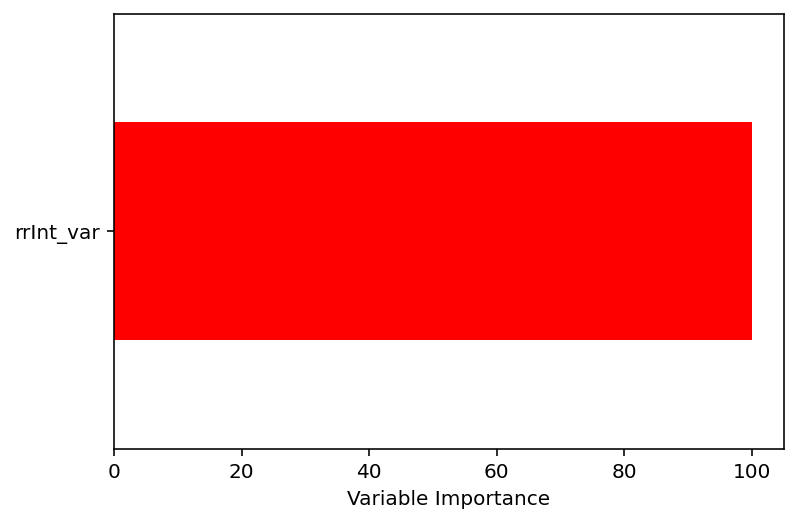

  4%|███▌                                                                               | 1/23 [00:03<01:25,  3.90s/it]

roc_auc_score 0.8492050014465954


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


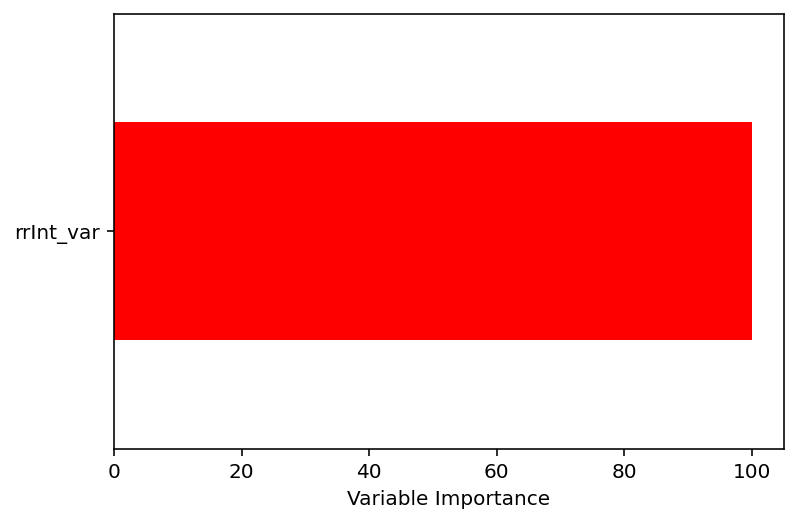

  9%|███████▏                                                                           | 2/23 [00:07<01:22,  3.91s/it]

roc_auc_score 0.9649688593824461


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


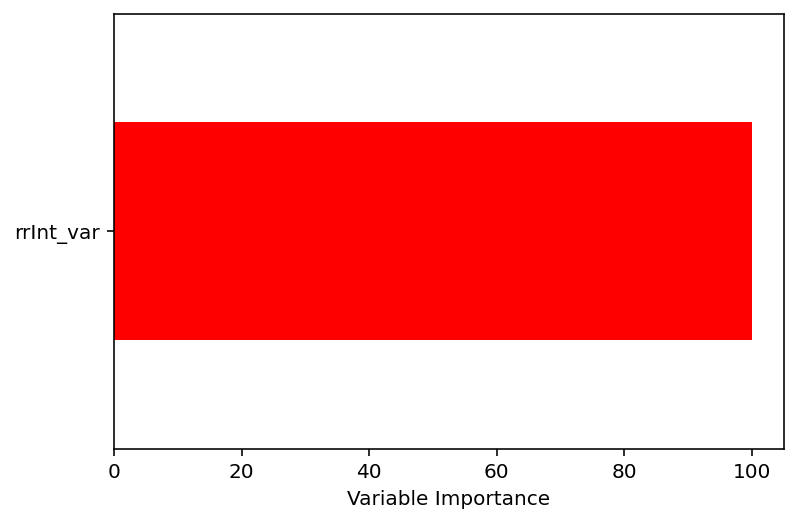

 13%|██████████▊                                                                        | 3/23 [00:11<01:18,  3.95s/it]

roc_auc_score 0.9661169560630685


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


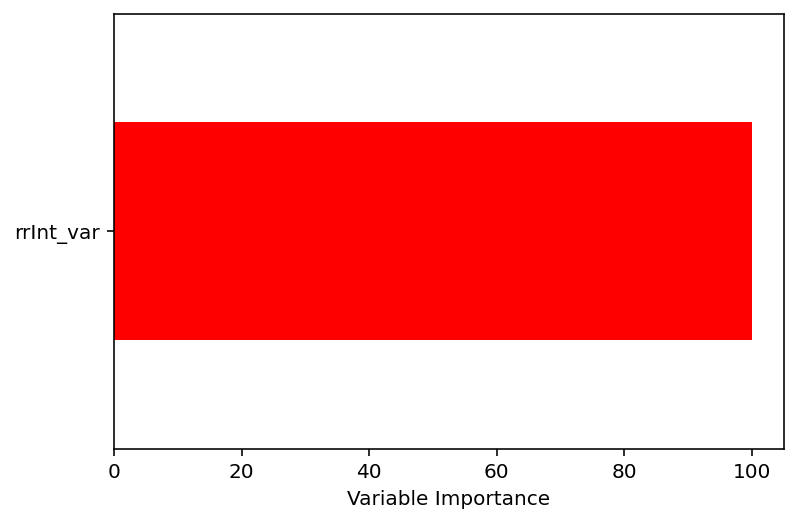

 17%|██████████████▍                                                                    | 4/23 [00:15<01:16,  4.04s/it]

roc_auc_score 0.6066455332234686


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


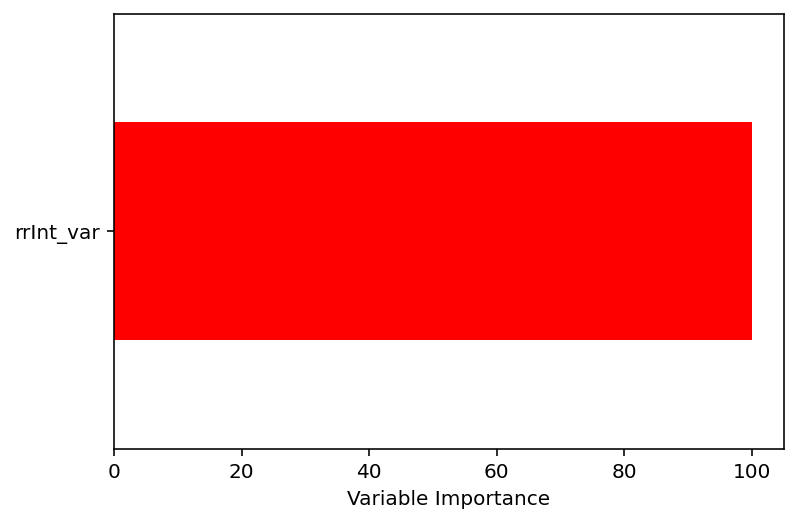

 22%|██████████████████                                                                 | 5/23 [00:20<01:14,  4.15s/it]

roc_auc_score 0.9498249337287583


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


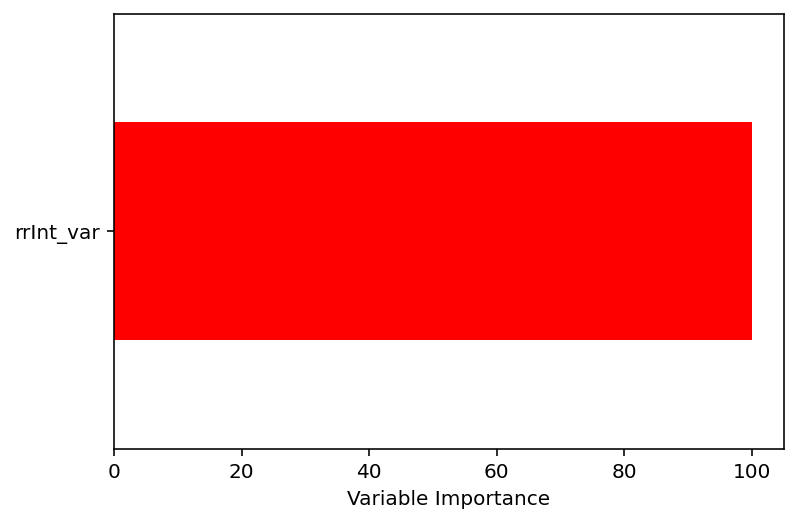

 26%|█████████████████████▋                                                             | 6/23 [00:24<01:12,  4.24s/it]

roc_auc_score 0.9345832248486292


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


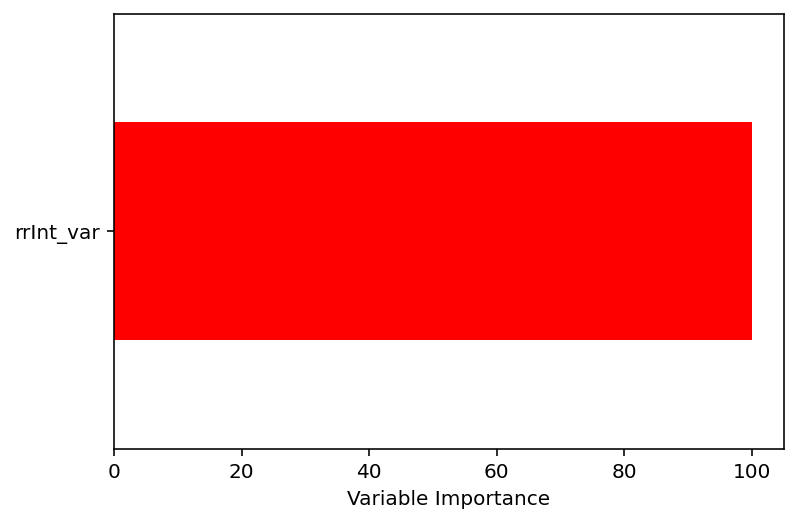

 30%|█████████████████████████▎                                                         | 7/23 [00:29<01:08,  4.28s/it]

roc_auc_score 0.9289112821786211


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


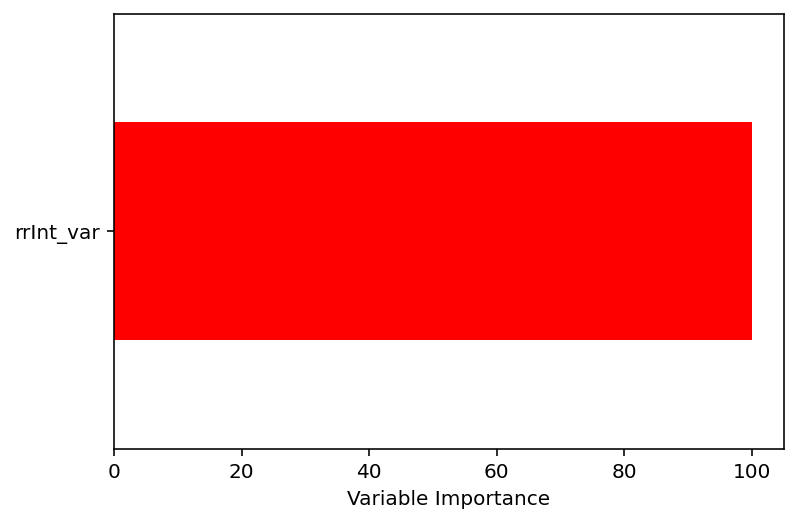

 35%|████████████████████████████▊                                                      | 8/23 [00:33<01:05,  4.38s/it]

roc_auc_score 0.9204875051793853


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


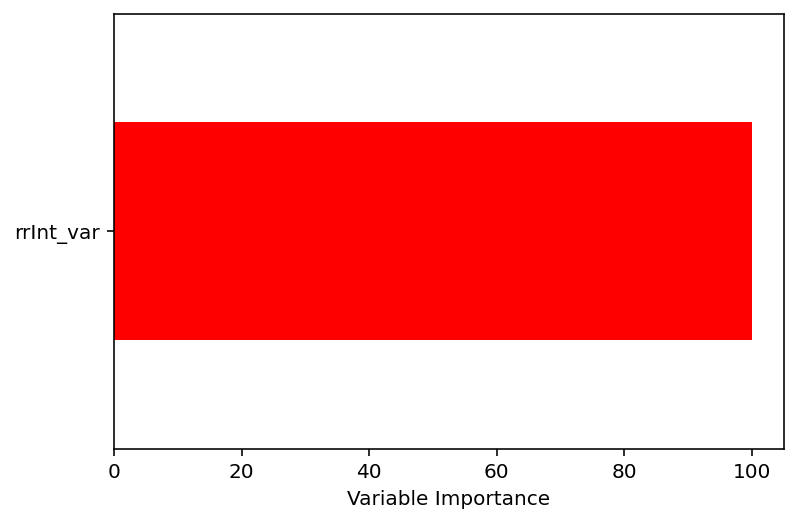

 39%|████████████████████████████████▍                                                  | 9/23 [00:38<01:01,  4.42s/it]

roc_auc_score 0.8679246975066569


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


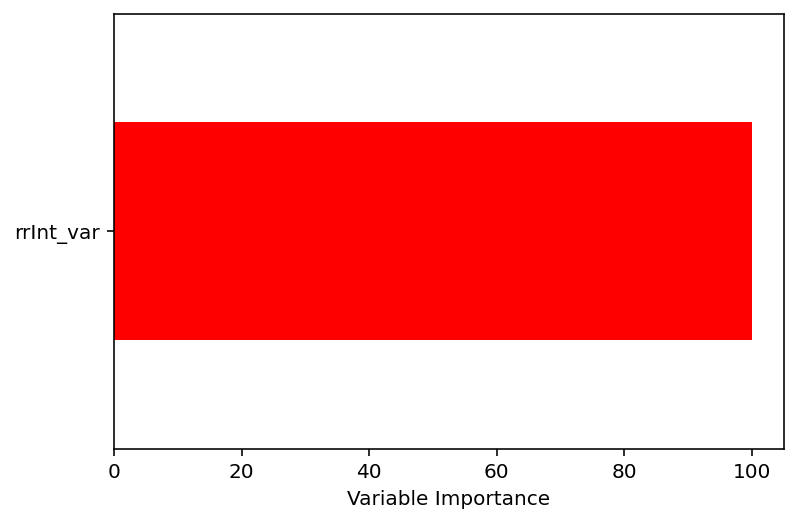

 43%|███████████████████████████████████▋                                              | 10/23 [00:42<00:58,  4.51s/it]

roc_auc_score 0.8536967721674772


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


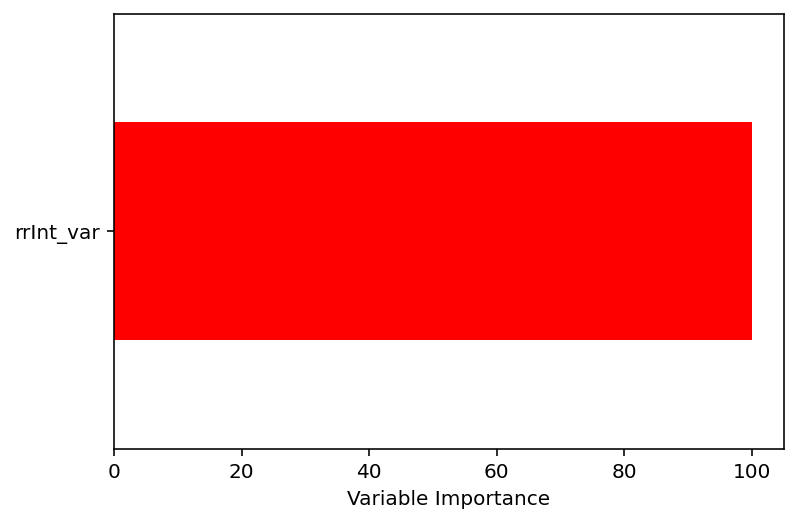

 48%|███████████████████████████████████████▏                                          | 11/23 [00:47<00:54,  4.55s/it]

roc_auc_score 0.6911187003927011


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


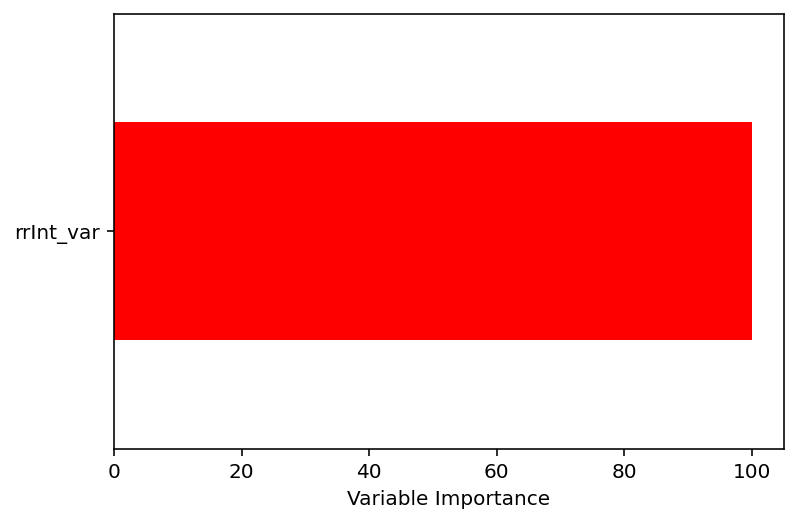

 52%|██████████████████████████████████████████▊                                       | 12/23 [00:52<00:50,  4.60s/it]

roc_auc_score 0.8861605347689716


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


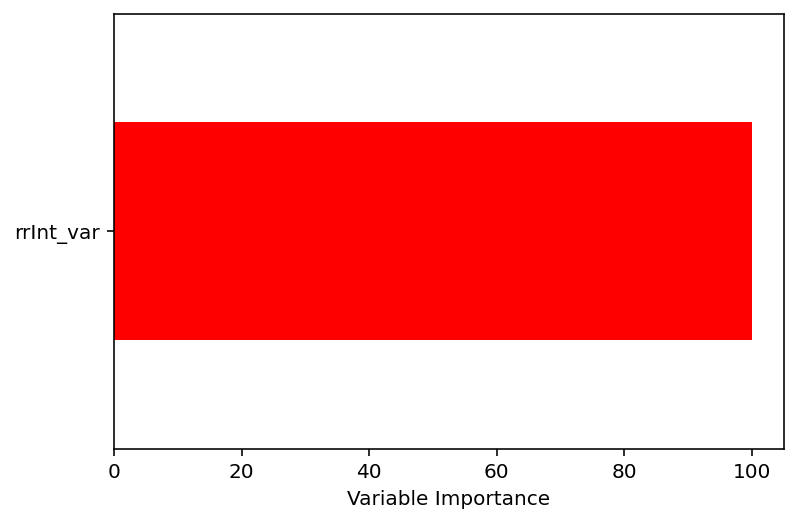

 57%|██████████████████████████████████████████████▎                                   | 13/23 [00:56<00:45,  4.59s/it]

roc_auc_score 0.8658300621330284


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


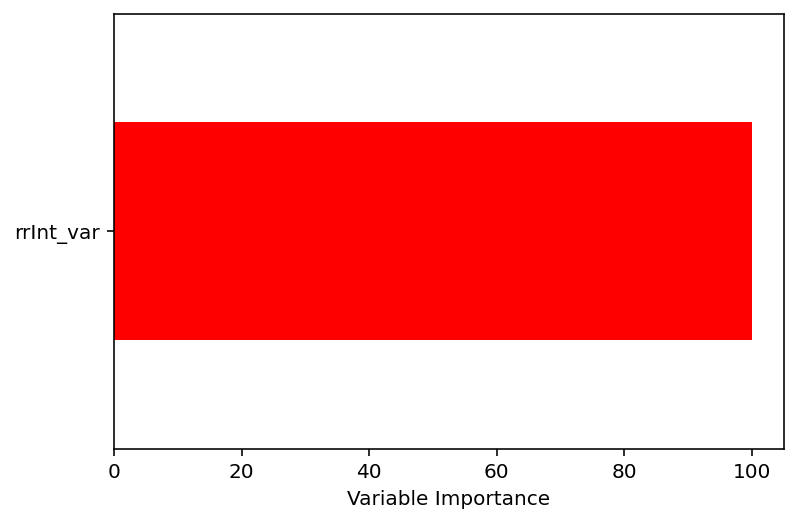

 70%|█████████████████████████████████████████████████████████                         | 16/23 [01:01<00:19,  2.81s/it]

roc_auc_score 0.8904455301405972


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


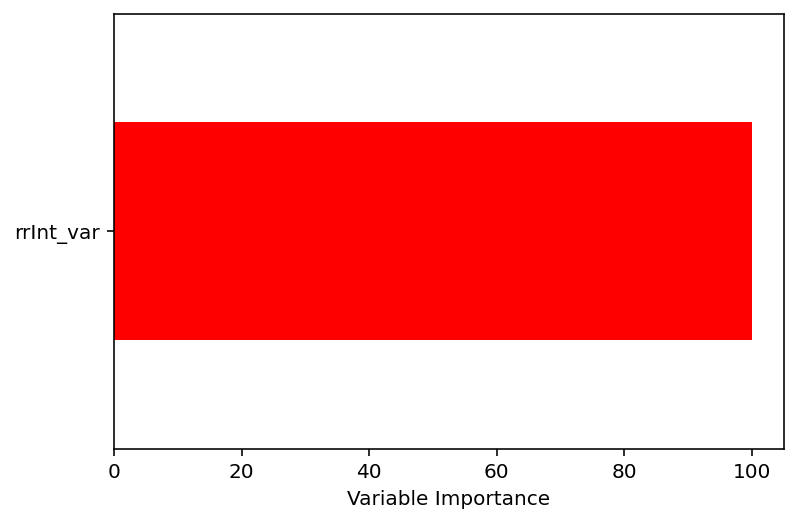

 74%|████████████████████████████████████████████████████████████▌                     | 17/23 [01:05<00:18,  3.12s/it]

roc_auc_score 0.9372487169736505


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


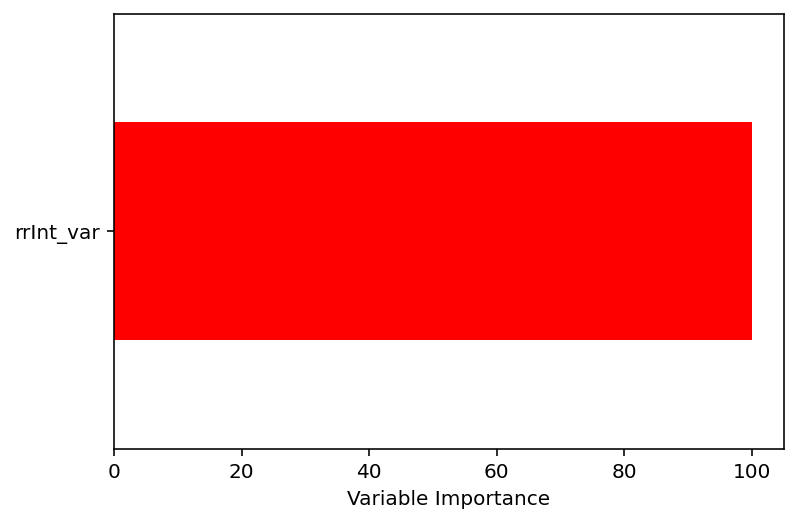

 78%|████████████████████████████████████████████████████████████████▏                 | 18/23 [01:09<00:17,  3.40s/it]

roc_auc_score 0.9680170495525449


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


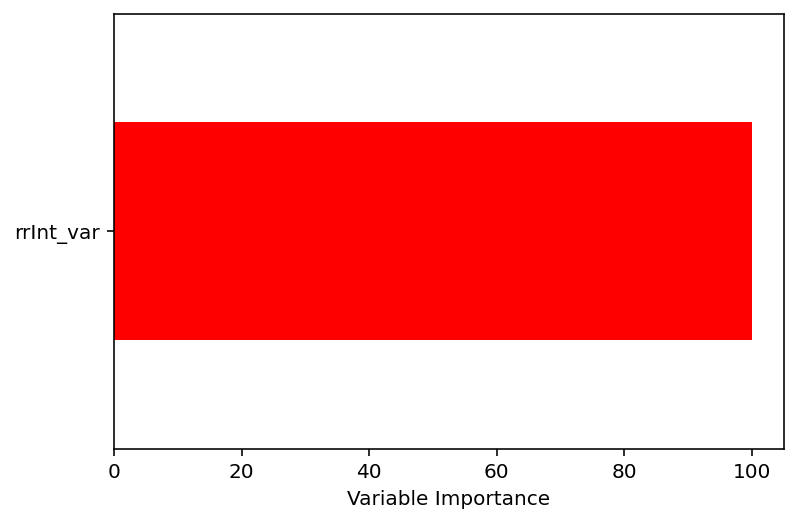

 83%|███████████████████████████████████████████████████████████████████▋              | 19/23 [01:14<00:14,  3.63s/it]

roc_auc_score 0.6508464443648472


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


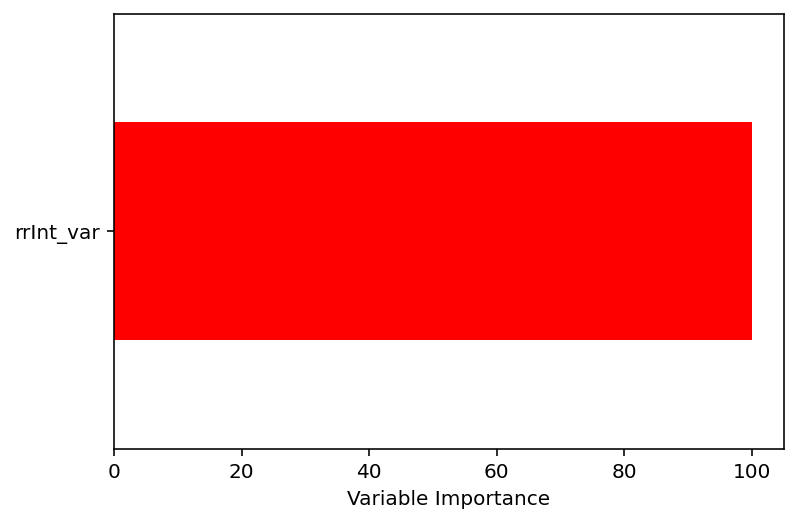

 87%|███████████████████████████████████████████████████████████████████████▎          | 20/23 [01:18<00:11,  3.82s/it]

roc_auc_score 0.9346763708499203


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


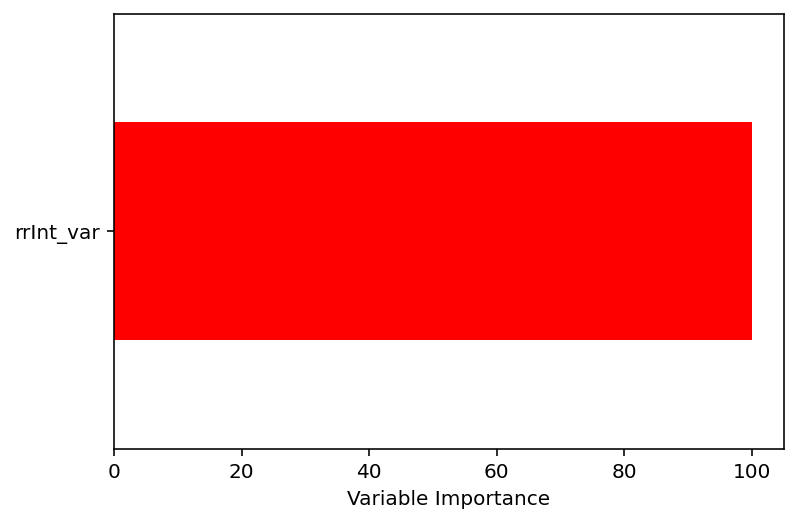

 91%|██████████████████████████████████████████████████████████████████████████▊       | 21/23 [01:22<00:07,  3.94s/it]

roc_auc_score 0.9729791390089422


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


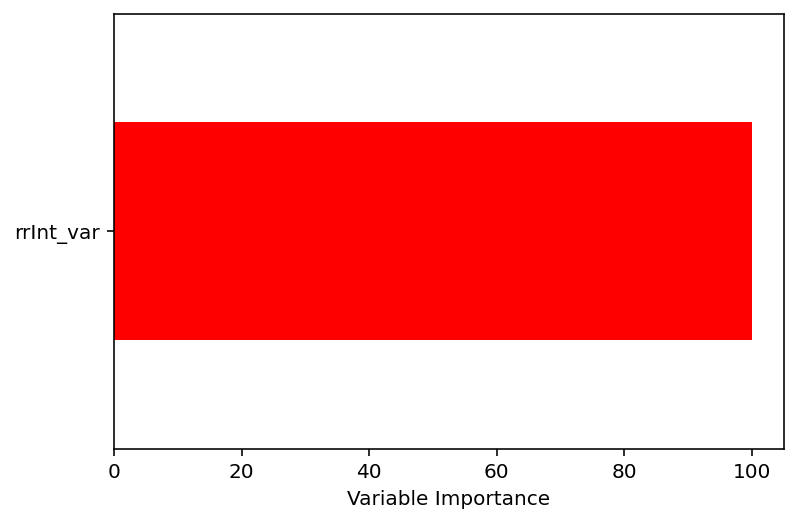

 96%|██████████████████████████████████████████████████████████████████████████████▍   | 22/23 [01:27<00:04,  4.05s/it]

roc_auc_score 0.9062078213593365


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


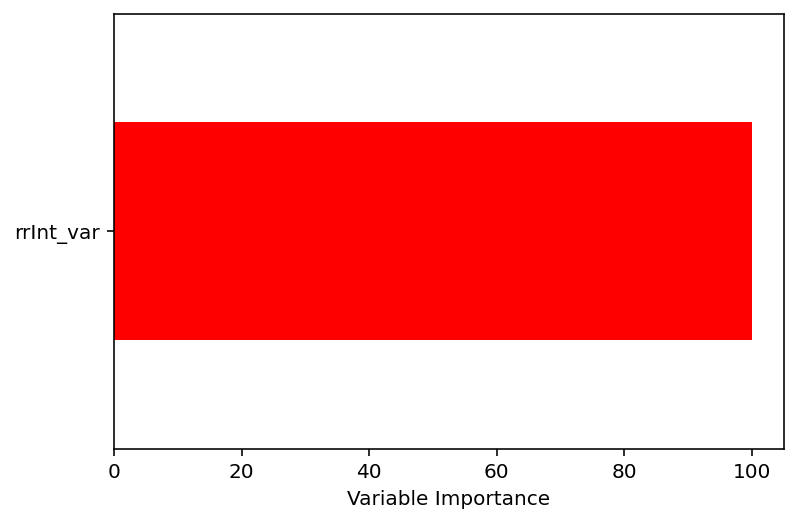

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [01:31<00:00,  3.97s/it]

roc_auc_score 0.9734198565157375
---Run time is 91.28339440003037 seconds ---

Accuracy of each fold: 
 [0.7849624060150376, 0.9241821182409474, 0.9093514328808446, 0.3782987085906794, 0.9346815726667504, 0.8935279805352798, 0.9034969737726967, 0.8620068751023081, 0.8666666666666667, 0.5333597569031576, 0.9657616399520227, 0.7058925177121134, 0.6413943355119825, 0.8012163892445583, 0.747227280251614, 0.9448993754337266, 0.43459744473737577, 0.8920454545454546, 0.9470942702481872, 0.8301117487163999, 0.9276196244700182]

Avg accuracy : 
0.8013521224856104

Std of accuracy : 
0.16739971654332797
[[73294 29591]
 [ 3597 64524]]
classification report: 


              precision    recall  f1-score   support

           0       0.95      0.71      0.82    102885
           1       0.69      0.95      0.80     68121

    accuracy                           0.81    171006
   macro avg       0.82      0.83      0.81    171006
weighted avg       0.85      0.81      0.81    171006



In [10]:
# XGBoost
print(xgb.__version__)
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

# Create the Extreme GBM
model = XGBClassifier(n_estimators=100, learning_rate = 0.1,use_label_encoder =False,verbose=None,
                max_depth = 5, eval_metric='logloss')

start_time = timeit.default_timer() #defines start time so computational time can be calculated

acc_score = []
Truth = []
Output = []
 
for train, test in tqdm(splits):
    X_train = X.iloc[train]
    y_train = y.iloc[train]

    X_test = X.iloc[test]
    y_test = y.iloc[test]

    a = y_test.to_numpy() # s.values (pandas<0.24)
    if (a[0] == a).all():
        continue
    
    model.fit(X_train,y_train)

    pred_values = model.predict(X_test)
    pred_prob = model.predict_proba(X_test)[:, 1]
     
    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)
    
    Truth.extend(y_test.values.reshape(y_test.shape[0])); ## it is a list
    Output.extend(pred_values); ## it is a list 
    
    #print(model.feature_importances_)
    Importance = pd.DataFrame({'Importance':(model.feature_importances_*100)[0:10]}, 
                          index = (X_train.columns)[0:10])
    Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r')
    plt.xlabel('Variable Importance')
    plt.gca().legend_ = None
    plt.show()
    #plt.savefig('plot1.png')
    
    ##################################################
    #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html
    #Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.
    print("roc_auc_score", roc_auc_score(y_test, pred_prob))
    
    # calculate the fpr and tpr for all thresholds of the classification
    #fpr, tpr, threshold = metrics.roc_curve(y_test, pred_prob)
    #roc_auc = metrics.auc(fpr, tpr)
    # method I: plt
    #import matplotlib.pyplot as plt
    #plt.title('Receiver Operating Characteristic')
    #plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    #plt.legend(loc = 'lower right')
    #plt.plot([0, 1], [0, 1],'r--')
    #plt.xlim([-0.05, 1])
    #plt.ylim([0, 1.05])
    #plt.ylabel('True Positive Rate')
    #plt.xlabel('False Positive Rate')
    #plt.show()
    ##################################################
    
elapsed = timeit.default_timer() - start_time #gives total computation time
print("---Run time is %s seconds ---" % elapsed) #prints computation time
print()

print('Accuracy of each fold: \n {}'.format(acc_score))
print()
print('Avg accuracy : \n{}'.format(np.mean(acc_score))); 
print()
print('Std of accuracy : \n{}'.format(np.std(acc_score)))

cm = confusion_matrix(Truth, Output)
print(cm)
print("classification report: ")
print(classification_report(Truth, Output))

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

performance_dict['Avg Accuracy'].append(np.mean(acc_score))
performance_dict['Std Accuracy'].append(np.std(acc_score))
performance_dict['Sensitivity'].append(sensitivity)
performance_dict['Specificity'].append(specificity)
performance_dict['Precision'].append(precision)
performance_dict['F1 score'].append(f1_score)
performance_dict['Run time'].append(elapsed)

  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

[0]	validation_0-logloss:0.63472	validation_1-logloss:0.64588
[1]	validation_0-logloss:0.58808	validation_1-logloss:0.60725
[2]	validation_0-logloss:0.55039	validation_1-logloss:0.57524
[3]	validation_0-logloss:0.51944	validation_1-logloss:0.54851


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[4]	validation_0-logloss:0.49380	validation_1-logloss:0.52589
[5]	validation_0-logloss:0.47243	validation_1-logloss:0.50671
[6]	validation_0-logloss:0.45452	validation_1-logloss:0.49028
[7]	validation_0-logloss:0.43947	validation_1-logloss:0.47621
[8]	validation_0-logloss:0.42675	validation_1-logloss:0.46412
[9]	validation_0-logloss:0.41594	validation_1-logloss:0.45363
[10]	validation_0-logloss:0.40682	validation_1-logloss:0.44458
[11]	validation_0-logloss:0.39904	validation_1-logloss:0.43671
[12]	validation_0-logloss:0.39238	validation_1-logloss:0.42987
[13]	validation_0-logloss:0.38672	validation_1-logloss:0.42392
[14]	validation_0-logloss:0.38185	validation_1-logloss:0.41872
[15]	validation_0-logloss:0.37765	validation_1-logloss:0.41417
[16]	validation_0-logloss:0.37402	validation_1-logloss:0.41018
[17]	validation_0-logloss:0.37089	validation_1-logloss:0.40669
[18]	validation_0-logloss:0.36817	validation_1-logloss:0.40363
[19]	validation_0-logloss:0.36584	validation_1-logloss:0.4009

  4%|███▌                                                                               | 1/23 [00:04<01:39,  4.51s/it]

[0]	validation_0-logloss:0.62365	validation_1-logloss:0.64733
[1]	validation_0-logloss:0.56658	validation_1-logloss:0.60988
[2]	validation_0-logloss:0.51898	validation_1-logloss:0.57890


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.47878	validation_1-logloss:0.55290
[4]	validation_0-logloss:0.44451	validation_1-logloss:0.53100
[5]	validation_0-logloss:0.41494	validation_1-logloss:0.51240
[6]	validation_0-logloss:0.38939	validation_1-logloss:0.49646
[7]	validation_0-logloss:0.36719	validation_1-logloss:0.48282
[8]	validation_0-logloss:0.34784	validation_1-logloss:0.47106
[9]	validation_0-logloss:0.33089	validation_1-logloss:0.46092
[10]	validation_0-logloss:0.31597	validation_1-logloss:0.45213
[11]	validation_0-logloss:0.30282	validation_1-logloss:0.44449
[12]	validation_0-logloss:0.29124	validation_1-logloss:0.43784
[13]	validation_0-logloss:0.28099	validation_1-logloss:0.43204
[14]	validation_0-logloss:0.27191	validation_1-logloss:0.42697
[15]	validation_0-logloss:0.26383	validation_1-logloss:0.42255
[16]	validation_0-logloss:0.25671	validation_1-logloss:0.41866
[17]	validation_0-logloss:0.25035	validation_1-logloss:0.41525
[18]	validation_0-logloss:0.24471	validation_1-logloss:0.41227

  9%|███████▏                                                                           | 2/23 [00:09<01:34,  4.51s/it]

[0]	validation_0-logloss:0.61637	validation_1-logloss:0.64702
[1]	validation_0-logloss:0.55356	validation_1-logloss:0.60933
[2]	validation_0-logloss:0.50133	validation_1-logloss:0.57803


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.45728	validation_1-logloss:0.55188
[4]	validation_0-logloss:0.41979	validation_1-logloss:0.52986
[5]	validation_0-logloss:0.38761	validation_1-logloss:0.51110
[6]	validation_0-logloss:0.35977	validation_1-logloss:0.49507
[7]	validation_0-logloss:0.33554	validation_1-logloss:0.48134
[8]	validation_0-logloss:0.31445	validation_1-logloss:0.46950
[9]	validation_0-logloss:0.29592	validation_1-logloss:0.45930
[10]	validation_0-logloss:0.27968	validation_1-logloss:0.45043
[11]	validation_0-logloss:0.26530	validation_1-logloss:0.44276
[12]	validation_0-logloss:0.25257	validation_1-logloss:0.43608
[13]	validation_0-logloss:0.24126	validation_1-logloss:0.43025
[14]	validation_0-logloss:0.23126	validation_1-logloss:0.42518
[15]	validation_0-logloss:0.22234	validation_1-logloss:0.42072
[16]	validation_0-logloss:0.21436	validation_1-logloss:0.41682
[17]	validation_0-logloss:0.20728	validation_1-logloss:0.41340
[18]	validation_0-logloss:0.20092	validation_1-logloss:0.41040

 13%|██████████▊                                                                        | 3/23 [00:13<01:30,  4.53s/it]

[0]	validation_0-logloss:0.69693	validation_1-logloss:0.64283
[1]	validation_0-logloss:0.70310	validation_1-logloss:0.60174
[2]	validation_0-logloss:0.71075	validation_1-logloss:0.56771


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.71957	validation_1-logloss:0.53918
[4]	validation_0-logloss:0.72911	validation_1-logloss:0.51509
[5]	validation_0-logloss:0.73903	validation_1-logloss:0.49458
[6]	validation_0-logloss:0.74909	validation_1-logloss:0.47707
[7]	validation_0-logloss:0.75919	validation_1-logloss:0.46206
[8]	validation_0-logloss:0.76906	validation_1-logloss:0.44913
[9]	validation_0-logloss:0.77884	validation_1-logloss:0.43792
[10]	validation_0-logloss:0.78823	validation_1-logloss:0.42822
[11]	validation_0-logloss:0.79726	validation_1-logloss:0.41980
[12]	validation_0-logloss:0.80594	validation_1-logloss:0.41249
[13]	validation_0-logloss:0.81414	validation_1-logloss:0.40608
[14]	validation_0-logloss:0.82190	validation_1-logloss:0.40049
[15]	validation_0-logloss:0.82927	validation_1-logloss:0.39562
[16]	validation_0-logloss:0.83614	validation_1-logloss:0.39137
[17]	validation_0-logloss:0.84274	validation_1-logloss:0.38761
[18]	validation_0-logloss:0.84875	validation_1-logloss:0.38430

 17%|██████████████▍                                                                    | 4/23 [00:18<01:26,  4.53s/it]

[0]	validation_0-logloss:0.63514	validation_1-logloss:0.64690
[1]	validation_0-logloss:0.58670	validation_1-logloss:0.60913
[2]	validation_0-logloss:0.54589	validation_1-logloss:0.57783
[3]	validation_0-logloss:0.51106	validation_1-logloss:0.55160


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[4]	validation_0-logloss:0.48111	validation_1-logloss:0.52941
[5]	validation_0-logloss:0.45531	validation_1-logloss:0.51058
[6]	validation_0-logloss:0.43280	validation_1-logloss:0.49443
[7]	validation_0-logloss:0.41317	validation_1-logloss:0.48057
[8]	validation_0-logloss:0.39602	validation_1-logloss:0.46860
[9]	validation_0-logloss:0.38095	validation_1-logloss:0.45828
[10]	validation_0-logloss:0.36764	validation_1-logloss:0.44934
[11]	validation_0-logloss:0.35589	validation_1-logloss:0.44154
[12]	validation_0-logloss:0.34549	validation_1-logloss:0.43474
[13]	validation_0-logloss:0.33626	validation_1-logloss:0.42878
[14]	validation_0-logloss:0.32811	validation_1-logloss:0.42360
[15]	validation_0-logloss:0.32087	validation_1-logloss:0.41903
[16]	validation_0-logloss:0.31436	validation_1-logloss:0.41503
[17]	validation_0-logloss:0.30868	validation_1-logloss:0.41152
[18]	validation_0-logloss:0.30352	validation_1-logloss:0.40841
[19]	validation_0-logloss:0.29899	validation_1-logloss:0.4056

 22%|██████████████████                                                                 | 5/23 [00:22<01:20,  4.48s/it]

[0]	validation_0-logloss:0.62036	validation_1-logloss:0.64725
[1]	validation_0-logloss:0.56111	validation_1-logloss:0.60971
[2]	validation_0-logloss:0.51189	validation_1-logloss:0.57864


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.47068	validation_1-logloss:0.55261
[4]	validation_0-logloss:0.43567	validation_1-logloss:0.53067
[5]	validation_0-logloss:0.40575	validation_1-logloss:0.51204
[6]	validation_0-logloss:0.38003	validation_1-logloss:0.49613
[7]	validation_0-logloss:0.35777	validation_1-logloss:0.48251
[8]	validation_0-logloss:0.33842	validation_1-logloss:0.47079
[9]	validation_0-logloss:0.32152	validation_1-logloss:0.46066
[10]	validation_0-logloss:0.30676	validation_1-logloss:0.45189
[11]	validation_0-logloss:0.29377	validation_1-logloss:0.44429
[12]	validation_0-logloss:0.28232	validation_1-logloss:0.43768
[13]	validation_0-logloss:0.27219	validation_1-logloss:0.43191
[14]	validation_0-logloss:0.26324	validation_1-logloss:0.42689
[15]	validation_0-logloss:0.25532	validation_1-logloss:0.42249
[16]	validation_0-logloss:0.24826	validation_1-logloss:0.41865
[17]	validation_0-logloss:0.24198	validation_1-logloss:0.41527
[18]	validation_0-logloss:0.23640	validation_1-logloss:0.41233

 26%|█████████████████████▋                                                             | 6/23 [00:26<01:15,  4.43s/it]

[0]	validation_0-logloss:0.64248	validation_1-logloss:0.64642
[1]	validation_0-logloss:0.60067	validation_1-logloss:0.60822
[2]	validation_0-logloss:0.56577	validation_1-logloss:0.57653


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.53642	validation_1-logloss:0.55000
[4]	validation_0-logloss:0.51155	validation_1-logloss:0.52754
[5]	validation_0-logloss:0.49044	validation_1-logloss:0.50841
[6]	validation_0-logloss:0.47249	validation_1-logloss:0.49204
[7]	validation_0-logloss:0.45723	validation_1-logloss:0.47798
[8]	validation_0-logloss:0.44423	validation_1-logloss:0.46578
[9]	validation_0-logloss:0.43324	validation_1-logloss:0.45525
[10]	validation_0-logloss:0.42389	validation_1-logloss:0.44606
[11]	validation_0-logloss:0.41600	validation_1-logloss:0.43803
[12]	validation_0-logloss:0.40941	validation_1-logloss:0.43106
[13]	validation_0-logloss:0.40387	validation_1-logloss:0.42493
[14]	validation_0-logloss:0.39933	validation_1-logloss:0.41957
[15]	validation_0-logloss:0.39563	validation_1-logloss:0.41484
[16]	validation_0-logloss:0.39261	validation_1-logloss:0.41065
[17]	validation_0-logloss:0.39025	validation_1-logloss:0.40697
[18]	validation_0-logloss:0.38853	validation_1-logloss:0.40371

 30%|█████████████████████████▎                                                         | 7/23 [00:31<01:09,  4.36s/it]

[0]	validation_0-logloss:0.62401	validation_1-logloss:0.64643
[1]	validation_0-logloss:0.56791	validation_1-logloss:0.60834
[2]	validation_0-logloss:0.52220	validation_1-logloss:0.57677


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.48400	validation_1-logloss:0.55030
[4]	validation_0-logloss:0.45175	validation_1-logloss:0.52802
[5]	validation_0-logloss:0.42431	validation_1-logloss:0.50903
[6]	validation_0-logloss:0.40077	validation_1-logloss:0.49283
[7]	validation_0-logloss:0.38046	validation_1-logloss:0.47895
[8]	validation_0-logloss:0.36288	validation_1-logloss:0.46697
[9]	validation_0-logloss:0.34757	validation_1-logloss:0.45664
[10]	validation_0-logloss:0.33427	validation_1-logloss:0.44770
[11]	validation_0-logloss:0.32266	validation_1-logloss:0.43994
[12]	validation_0-logloss:0.31249	validation_1-logloss:0.43317
[13]	validation_0-logloss:0.30355	validation_1-logloss:0.42728
[14]	validation_0-logloss:0.29569	validation_1-logloss:0.42214
[15]	validation_0-logloss:0.28879	validation_1-logloss:0.41765
[16]	validation_0-logloss:0.28269	validation_1-logloss:0.41371
[17]	validation_0-logloss:0.27724	validation_1-logloss:0.41025
[18]	validation_0-logloss:0.27234	validation_1-logloss:0.40721

 35%|████████████████████████████▊                                                      | 8/23 [00:35<01:06,  4.40s/it]

[0]	validation_0-logloss:0.65094	validation_1-logloss:0.64607
[1]	validation_0-logloss:0.61577	validation_1-logloss:0.60761
[2]	validation_0-logloss:0.58617	validation_1-logloss:0.57572


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.56102	validation_1-logloss:0.54900
[4]	validation_0-logloss:0.53957	validation_1-logloss:0.52642
[5]	validation_0-logloss:0.52112	validation_1-logloss:0.50722
[6]	validation_0-logloss:0.50516	validation_1-logloss:0.49081
[7]	validation_0-logloss:0.49137	validation_1-logloss:0.47669
[8]	validation_0-logloss:0.47940	validation_1-logloss:0.46451
[9]	validation_0-logloss:0.46890	validation_1-logloss:0.45396
[10]	validation_0-logloss:0.45973	validation_1-logloss:0.44483
[11]	validation_0-logloss:0.45171	validation_1-logloss:0.43686
[12]	validation_0-logloss:0.44465	validation_1-logloss:0.42994
[13]	validation_0-logloss:0.43844	validation_1-logloss:0.42387
[14]	validation_0-logloss:0.43295	validation_1-logloss:0.41857
[15]	validation_0-logloss:0.42809	validation_1-logloss:0.41394
[16]	validation_0-logloss:0.42381	validation_1-logloss:0.40985
[17]	validation_0-logloss:0.42000	validation_1-logloss:0.40626
[18]	validation_0-logloss:0.41664	validation_1-logloss:0.40309

 39%|████████████████████████████████▍                                                  | 9/23 [00:40<01:02,  4.43s/it]

[0]	validation_0-logloss:0.67105	validation_1-logloss:0.64373
[1]	validation_0-logloss:0.65580	validation_1-logloss:0.60338
[2]	validation_0-logloss:0.64560	validation_1-logloss:0.56990


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.63913	validation_1-logloss:0.54191
[4]	validation_0-logloss:0.63546	validation_1-logloss:0.51825
[5]	validation_0-logloss:0.63386	validation_1-logloss:0.49818
[6]	validation_0-logloss:0.63393	validation_1-logloss:0.48102
[7]	validation_0-logloss:0.63516	validation_1-logloss:0.46628
[8]	validation_0-logloss:0.63732	validation_1-logloss:0.45355
[9]	validation_0-logloss:0.64009	validation_1-logloss:0.44262
[10]	validation_0-logloss:0.64331	validation_1-logloss:0.43311
[11]	validation_0-logloss:0.64690	validation_1-logloss:0.42487
[12]	validation_0-logloss:0.65065	validation_1-logloss:0.41770
[13]	validation_0-logloss:0.65450	validation_1-logloss:0.41146
[14]	validation_0-logloss:0.65839	validation_1-logloss:0.40601
[15]	validation_0-logloss:0.66220	validation_1-logloss:0.40126
[16]	validation_0-logloss:0.66592	validation_1-logloss:0.39707
[17]	validation_0-logloss:0.66951	validation_1-logloss:0.39340
[18]	validation_0-logloss:0.67297	validation_1-logloss:0.39020

 43%|███████████████████████████████████▋                                              | 10/23 [00:44<00:58,  4.48s/it]

[0]	validation_0-logloss:0.64317	validation_1-logloss:0.64709
[1]	validation_0-logloss:0.60074	validation_1-logloss:0.60947
[2]	validation_0-logloss:0.56435	validation_1-logloss:0.57825


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.53343	validation_1-logloss:0.55210
[4]	validation_0-logloss:0.50621	validation_1-logloss:0.52995
[5]	validation_0-logloss:0.48251	validation_1-logloss:0.51112
[6]	validation_0-logloss:0.46160	validation_1-logloss:0.49501
[7]	validation_0-logloss:0.44326	validation_1-logloss:0.48114
[8]	validation_0-logloss:0.42746	validation_1-logloss:0.46919
[9]	validation_0-logloss:0.41313	validation_1-logloss:0.45881
[10]	validation_0-logloss:0.40051	validation_1-logloss:0.44983
[11]	validation_0-logloss:0.38930	validation_1-logloss:0.44195
[12]	validation_0-logloss:0.37945	validation_1-logloss:0.43512
[13]	validation_0-logloss:0.37061	validation_1-logloss:0.42912
[14]	validation_0-logloss:0.36281	validation_1-logloss:0.42387
[15]	validation_0-logloss:0.35589	validation_1-logloss:0.41928
[16]	validation_0-logloss:0.34968	validation_1-logloss:0.41522
[17]	validation_0-logloss:0.34418	validation_1-logloss:0.41163
[18]	validation_0-logloss:0.33916	validation_1-logloss:0.40849

 48%|███████████████████████████████████████▏                                          | 11/23 [00:49<00:53,  4.49s/it]

[0]	validation_0-logloss:0.64582	validation_1-logloss:0.64560
[1]	validation_0-logloss:0.60814	validation_1-logloss:0.60671
[2]	validation_0-logloss:0.57768	validation_1-logloss:0.57457


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.55293	validation_1-logloss:0.54761
[4]	validation_0-logloss:0.53253	validation_1-logloss:0.52485
[5]	validation_0-logloss:0.51559	validation_1-logloss:0.50557
[6]	validation_0-logloss:0.50143	validation_1-logloss:0.48904
[7]	validation_0-logloss:0.48959	validation_1-logloss:0.47484
[8]	validation_0-logloss:0.47961	validation_1-logloss:0.46264
[9]	validation_0-logloss:0.47120	validation_1-logloss:0.45211
[10]	validation_0-logloss:0.46410	validation_1-logloss:0.44296
[11]	validation_0-logloss:0.45804	validation_1-logloss:0.43504
[12]	validation_0-logloss:0.45288	validation_1-logloss:0.42815
[13]	validation_0-logloss:0.44848	validation_1-logloss:0.42211
[14]	validation_0-logloss:0.44475	validation_1-logloss:0.41687
[15]	validation_0-logloss:0.44144	validation_1-logloss:0.41226
[16]	validation_0-logloss:0.43875	validation_1-logloss:0.40824
[17]	validation_0-logloss:0.43638	validation_1-logloss:0.40469
[18]	validation_0-logloss:0.43437	validation_1-logloss:0.40158

 52%|██████████████████████████████████████████▊                                       | 12/23 [00:53<00:49,  4.54s/it]

[0]	validation_0-logloss:0.67280	validation_1-logloss:0.64471
[1]	validation_0-logloss:0.65612	validation_1-logloss:0.60513
[2]	validation_0-logloss:0.64225	validation_1-logloss:0.57232


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.63076	validation_1-logloss:0.54480
[4]	validation_0-logloss:0.62115	validation_1-logloss:0.52159
[5]	validation_0-logloss:0.61302	validation_1-logloss:0.50187
[6]	validation_0-logloss:0.60617	validation_1-logloss:0.48498
[7]	validation_0-logloss:0.60039	validation_1-logloss:0.47046
[8]	validation_0-logloss:0.59558	validation_1-logloss:0.45793
[9]	validation_0-logloss:0.59138	validation_1-logloss:0.44711
[10]	validation_0-logloss:0.58780	validation_1-logloss:0.43772
[11]	validation_0-logloss:0.58474	validation_1-logloss:0.42954
[12]	validation_0-logloss:0.58224	validation_1-logloss:0.42244
[13]	validation_0-logloss:0.58013	validation_1-logloss:0.41622
[14]	validation_0-logloss:0.57820	validation_1-logloss:0.41077
[15]	validation_0-logloss:0.57666	validation_1-logloss:0.40598
[16]	validation_0-logloss:0.57522	validation_1-logloss:0.40180
[17]	validation_0-logloss:0.57402	validation_1-logloss:0.39810
[18]	validation_0-logloss:0.57304	validation_1-logloss:0.39485

 57%|██████████████████████████████████████████████▎                                   | 13/23 [00:58<00:45,  4.52s/it]

[0]	validation_0-logloss:0.66499	validation_1-logloss:0.64631
[1]	validation_0-logloss:0.64109	validation_1-logloss:0.60803
[2]	validation_0-logloss:0.62176	validation_1-logloss:0.57632


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.60526	validation_1-logloss:0.54974
[4]	validation_0-logloss:0.59120	validation_1-logloss:0.52722
[5]	validation_0-logloss:0.57901	validation_1-logloss:0.50810
[6]	validation_0-logloss:0.56881	validation_1-logloss:0.49177
[7]	validation_0-logloss:0.56042	validation_1-logloss:0.47770
[8]	validation_0-logloss:0.55276	validation_1-logloss:0.46558
[9]	validation_0-logloss:0.54583	validation_1-logloss:0.45504
[10]	validation_0-logloss:0.53970	validation_1-logloss:0.44594
[11]	validation_0-logloss:0.53543	validation_1-logloss:0.43801
[12]	validation_0-logloss:0.53082	validation_1-logloss:0.43108
[13]	validation_0-logloss:0.52768	validation_1-logloss:0.42504
[14]	validation_0-logloss:0.52472	validation_1-logloss:0.41974
[15]	validation_0-logloss:0.52212	validation_1-logloss:0.41507
[16]	validation_0-logloss:0.51924	validation_1-logloss:0.41099
[17]	validation_0-logloss:0.51702	validation_1-logloss:0.40739
[18]	validation_0-logloss:0.51527	validation_1-logloss:0.40421

 61%|█████████████████████████████████████████████████▉                                | 14/23 [01:02<00:40,  4.53s/it]

[0]	validation_0-logloss:0.71474	validation_1-logloss:0.64198
[1]	validation_0-logloss:0.73588	validation_1-logloss:0.60020
[2]	validation_0-logloss:0.75637	validation_1-logloss:0.56556


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.77625	validation_1-logloss:0.53656
[4]	validation_0-logloss:0.79526	validation_1-logloss:0.51211
[5]	validation_0-logloss:0.81342	validation_1-logloss:0.49131
[6]	validation_0-logloss:0.83070	validation_1-logloss:0.47348
[7]	validation_0-logloss:0.84717	validation_1-logloss:0.45824
[8]	validation_0-logloss:0.86271	validation_1-logloss:0.44507
[9]	validation_0-logloss:0.87729	validation_1-logloss:0.43370
[10]	validation_0-logloss:0.89107	validation_1-logloss:0.42385
[11]	validation_0-logloss:0.90396	validation_1-logloss:0.41528
[12]	validation_0-logloss:0.91594	validation_1-logloss:0.40782
[13]	validation_0-logloss:0.92703	validation_1-logloss:0.40132
[14]	validation_0-logloss:0.93742	validation_1-logloss:0.39563
[15]	validation_0-logloss:0.94707	validation_1-logloss:0.39066
[16]	validation_0-logloss:0.95582	validation_1-logloss:0.38630
[17]	validation_0-logloss:0.96412	validation_1-logloss:0.38246
[18]	validation_0-logloss:0.97168	validation_1-logloss:0.37909

 65%|█████████████████████████████████████████████████████▍                            | 15/23 [01:07<00:35,  4.49s/it]

[0]	validation_0-logloss:0.65557	validation_1-logloss:0.64575
[1]	validation_0-logloss:0.62426	validation_1-logloss:0.60701
[2]	validation_0-logloss:0.59816	validation_1-logloss:0.57490


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.57611	validation_1-logloss:0.54797
[4]	validation_0-logloss:0.55730	validation_1-logloss:0.52526
[5]	validation_0-logloss:0.54109	validation_1-logloss:0.50593
[6]	validation_0-logloss:0.52731	validation_1-logloss:0.48942
[7]	validation_0-logloss:0.51525	validation_1-logloss:0.47520
[8]	validation_0-logloss:0.50494	validation_1-logloss:0.46296
[9]	validation_0-logloss:0.49598	validation_1-logloss:0.45235
[10]	validation_0-logloss:0.48815	validation_1-logloss:0.44316
[11]	validation_0-logloss:0.48137	validation_1-logloss:0.43514
[12]	validation_0-logloss:0.47525	validation_1-logloss:0.42818
[13]	validation_0-logloss:0.47001	validation_1-logloss:0.42210
[14]	validation_0-logloss:0.46536	validation_1-logloss:0.41676
[15]	validation_0-logloss:0.46122	validation_1-logloss:0.41211
[16]	validation_0-logloss:0.45764	validation_1-logloss:0.40800
[17]	validation_0-logloss:0.45449	validation_1-logloss:0.40439
[18]	validation_0-logloss:0.45156	validation_1-logloss:0.40123

 70%|█████████████████████████████████████████████████████████                         | 16/23 [01:11<00:31,  4.47s/it]

[0]	validation_0-logloss:0.64869	validation_1-logloss:0.64559
[1]	validation_0-logloss:0.61332	validation_1-logloss:0.60667
[2]	validation_0-logloss:0.58466	validation_1-logloss:0.57442


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.56126	validation_1-logloss:0.54749
[4]	validation_0-logloss:0.54195	validation_1-logloss:0.52472
[5]	validation_0-logloss:0.52594	validation_1-logloss:0.50533
[6]	validation_0-logloss:0.51279	validation_1-logloss:0.48880
[7]	validation_0-logloss:0.50166	validation_1-logloss:0.47460
[8]	validation_0-logloss:0.49238	validation_1-logloss:0.46234
[9]	validation_0-logloss:0.48466	validation_1-logloss:0.45180
[10]	validation_0-logloss:0.47813	validation_1-logloss:0.44263
[11]	validation_0-logloss:0.47298	validation_1-logloss:0.43466
[12]	validation_0-logloss:0.46840	validation_1-logloss:0.42772
[13]	validation_0-logloss:0.46470	validation_1-logloss:0.42169
[14]	validation_0-logloss:0.46159	validation_1-logloss:0.41642
[15]	validation_0-logloss:0.45899	validation_1-logloss:0.41177
[16]	validation_0-logloss:0.45676	validation_1-logloss:0.40772
[17]	validation_0-logloss:0.45489	validation_1-logloss:0.40416
[18]	validation_0-logloss:0.45309	validation_1-logloss:0.40102

 74%|████████████████████████████████████████████████████████████▌                     | 17/23 [01:16<00:26,  4.49s/it]

[0]	validation_0-logloss:0.63550	validation_1-logloss:0.64697
[1]	validation_0-logloss:0.58735	validation_1-logloss:0.60918
[2]	validation_0-logloss:0.54623	validation_1-logloss:0.57792


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.51114	validation_1-logloss:0.55174
[4]	validation_0-logloss:0.48064	validation_1-logloss:0.52958
[5]	validation_0-logloss:0.45436	validation_1-logloss:0.51075
[6]	validation_0-logloss:0.43130	validation_1-logloss:0.49465
[7]	validation_0-logloss:0.41141	validation_1-logloss:0.48082
[8]	validation_0-logloss:0.39373	validation_1-logloss:0.46888
[9]	validation_0-logloss:0.37793	validation_1-logloss:0.45856
[10]	validation_0-logloss:0.36405	validation_1-logloss:0.44957
[11]	validation_0-logloss:0.35186	validation_1-logloss:0.44179
[12]	validation_0-logloss:0.34105	validation_1-logloss:0.43498
[13]	validation_0-logloss:0.33136	validation_1-logloss:0.42905
[14]	validation_0-logloss:0.32288	validation_1-logloss:0.42385
[15]	validation_0-logloss:0.31524	validation_1-logloss:0.41927
[16]	validation_0-logloss:0.30838	validation_1-logloss:0.41527
[17]	validation_0-logloss:0.30227	validation_1-logloss:0.41171
[18]	validation_0-logloss:0.29677	validation_1-logloss:0.40860

 78%|████████████████████████████████████████████████████████████████▏                 | 18/23 [01:20<00:22,  4.49s/it]

[0]	validation_0-logloss:0.69303	validation_1-logloss:0.64214
[1]	validation_0-logloss:0.69547	validation_1-logloss:0.60049
[2]	validation_0-logloss:0.69961	validation_1-logloss:0.56596


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.70503	validation_1-logloss:0.53700
[4]	validation_0-logloss:0.71127	validation_1-logloss:0.51255
[5]	validation_0-logloss:0.71804	validation_1-logloss:0.49179
[6]	validation_0-logloss:0.72513	validation_1-logloss:0.47403
[7]	validation_0-logloss:0.73234	validation_1-logloss:0.45878
[8]	validation_0-logloss:0.73965	validation_1-logloss:0.44567
[9]	validation_0-logloss:0.74679	validation_1-logloss:0.43431
[10]	validation_0-logloss:0.75380	validation_1-logloss:0.42446
[11]	validation_0-logloss:0.76066	validation_1-logloss:0.41594
[12]	validation_0-logloss:0.76715	validation_1-logloss:0.40852
[13]	validation_0-logloss:0.77342	validation_1-logloss:0.40201
[14]	validation_0-logloss:0.77938	validation_1-logloss:0.39632
[15]	validation_0-logloss:0.78496	validation_1-logloss:0.39138
[16]	validation_0-logloss:0.79029	validation_1-logloss:0.38700
[17]	validation_0-logloss:0.79525	validation_1-logloss:0.38317
[18]	validation_0-logloss:0.79990	validation_1-logloss:0.37981

 83%|███████████████████████████████████████████████████████████████████▋              | 19/23 [01:25<00:17,  4.47s/it]

[0]	validation_0-logloss:0.62811	validation_1-logloss:0.64665
[1]	validation_0-logloss:0.57496	validation_1-logloss:0.60864
[2]	validation_0-logloss:0.53083	validation_1-logloss:0.57712


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.49359	validation_1-logloss:0.55083
[4]	validation_0-logloss:0.46202	validation_1-logloss:0.52857
[5]	validation_0-logloss:0.43498	validation_1-logloss:0.50962
[6]	validation_0-logloss:0.41184	validation_1-logloss:0.49349
[7]	validation_0-logloss:0.39171	validation_1-logloss:0.47963
[8]	validation_0-logloss:0.37420	validation_1-logloss:0.46768
[9]	validation_0-logloss:0.35893	validation_1-logloss:0.45737
[10]	validation_0-logloss:0.34555	validation_1-logloss:0.44845
[11]	validation_0-logloss:0.33381	validation_1-logloss:0.44068
[12]	validation_0-logloss:0.32354	validation_1-logloss:0.43391
[13]	validation_0-logloss:0.31442	validation_1-logloss:0.42804
[14]	validation_0-logloss:0.30640	validation_1-logloss:0.42286
[15]	validation_0-logloss:0.29930	validation_1-logloss:0.41838
[16]	validation_0-logloss:0.29302	validation_1-logloss:0.41442
[17]	validation_0-logloss:0.28742	validation_1-logloss:0.41096
[18]	validation_0-logloss:0.28243	validation_1-logloss:0.40792

 87%|███████████████████████████████████████████████████████████████████████▎          | 20/23 [01:29<00:13,  4.50s/it]

[0]	validation_0-logloss:0.63745	validation_1-logloss:0.64721
[1]	validation_0-logloss:0.59058	validation_1-logloss:0.60963
[2]	validation_0-logloss:0.55074	validation_1-logloss:0.57850


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.51666	validation_1-logloss:0.55243
[4]	validation_0-logloss:0.48714	validation_1-logloss:0.53045
[5]	validation_0-logloss:0.46155	validation_1-logloss:0.51168
[6]	validation_0-logloss:0.43918	validation_1-logloss:0.49565
[7]	validation_0-logloss:0.41963	validation_1-logloss:0.48189
[8]	validation_0-logloss:0.40230	validation_1-logloss:0.46999
[9]	validation_0-logloss:0.38709	validation_1-logloss:0.45972
[10]	validation_0-logloss:0.37370	validation_1-logloss:0.45079
[11]	validation_0-logloss:0.36169	validation_1-logloss:0.44302
[12]	validation_0-logloss:0.35108	validation_1-logloss:0.43622
[13]	validation_0-logloss:0.34160	validation_1-logloss:0.43031
[14]	validation_0-logloss:0.33331	validation_1-logloss:0.42513
[15]	validation_0-logloss:0.32579	validation_1-logloss:0.42055
[16]	validation_0-logloss:0.31907	validation_1-logloss:0.41654
[17]	validation_0-logloss:0.31304	validation_1-logloss:0.41301
[18]	validation_0-logloss:0.30775	validation_1-logloss:0.40991

C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\pandas\plotting\_matplotlib\core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
 91%|██████████████████████████████████████████████████████████████████████████▊       | 21/23 [01:34<00:08,  4.49s/it]

[0]	validation_0-logloss:0.62940	validation_1-logloss:0.64636
[1]	validation_0-logloss:0.57770	validation_1-logloss:0.60812
[2]	validation_0-logloss:0.53540	validation_1-logloss:0.57644


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.49988	validation_1-logloss:0.54991
[4]	validation_0-logloss:0.46999	validation_1-logloss:0.52751
[5]	validation_0-logloss:0.44464	validation_1-logloss:0.50847
[6]	validation_0-logloss:0.42304	validation_1-logloss:0.49224
[7]	validation_0-logloss:0.40483	validation_1-logloss:0.47831
[8]	validation_0-logloss:0.38868	validation_1-logloss:0.46627
[9]	validation_0-logloss:0.37473	validation_1-logloss:0.45595
[10]	validation_0-logloss:0.36263	validation_1-logloss:0.44696
[11]	validation_0-logloss:0.35205	validation_1-logloss:0.43916
[12]	validation_0-logloss:0.34285	validation_1-logloss:0.43237
[13]	validation_0-logloss:0.33477	validation_1-logloss:0.42646
[14]	validation_0-logloss:0.32759	validation_1-logloss:0.42131
[15]	validation_0-logloss:0.32133	validation_1-logloss:0.41680
[16]	validation_0-logloss:0.31575	validation_1-logloss:0.41283
[17]	validation_0-logloss:0.31060	validation_1-logloss:0.40935
[18]	validation_0-logloss:0.30612	validation_1-logloss:0.40632

 96%|██████████████████████████████████████████████████████████████████████████████▍   | 22/23 [01:38<00:04,  4.52s/it]

[0]	validation_0-logloss:0.64100	validation_1-logloss:0.64694
[1]	validation_0-logloss:0.59729	validation_1-logloss:0.60916
[2]	validation_0-logloss:0.56018	validation_1-logloss:0.57787


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.52836	validation_1-logloss:0.55163
[4]	validation_0-logloss:0.50090	validation_1-logloss:0.52947
[5]	validation_0-logloss:0.47708	validation_1-logloss:0.51061
[6]	validation_0-logloss:0.45628	validation_1-logloss:0.49449
[7]	validation_0-logloss:0.43805	validation_1-logloss:0.48066
[8]	validation_0-logloss:0.42204	validation_1-logloss:0.46869
[9]	validation_0-logloss:0.40790	validation_1-logloss:0.45833
[10]	validation_0-logloss:0.39540	validation_1-logloss:0.44935
[11]	validation_0-logloss:0.38435	validation_1-logloss:0.44153
[12]	validation_0-logloss:0.37457	validation_1-logloss:0.43471
[13]	validation_0-logloss:0.36587	validation_1-logloss:0.42876
[14]	validation_0-logloss:0.35811	validation_1-logloss:0.42355
[15]	validation_0-logloss:0.35118	validation_1-logloss:0.41896
[16]	validation_0-logloss:0.34501	validation_1-logloss:0.41494
[17]	validation_0-logloss:0.33949	validation_1-logloss:0.41140
[18]	validation_0-logloss:0.33458	validation_1-logloss:0.40830

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [01:43<00:00,  4.48s/it]

---Run time is 103.1302585999947 seconds ---

Accuracy of each fold: 
 [0.7849624060150376, 0.9241821182409474, 0.9093514328808446, 0.3782987085906794, 0.9346815726667504, 0.8935279805352798, 0.9034969737726967, 0.8620068751023081, 0.8666666666666667, 0.5333597569031576, 0.9657616399520227, 0.7058925177121134, 0.6413943355119825, 0.7978853815507202, 0.2756109725685785, 0.8012163892445583, 0.747227280251614, 0.9448993754337266, 0.43459744473737577, 0.8920454545454546, 0.9470942702481872, 0.8301117487163999, 0.9276196244700182]

Avg accuracy : 
0.7783430837529184

Std of accuracy : 
0.19254758612568573
[[73294 29591]
 [12178 72494]]
classification report: 


              precision    recall  f1-score   support

           0       0.86      0.71      0.78    102885
           1       0.71      0.86      0.78     84672

    accuracy                           0.78    187557
   macro avg       0.78      0.78      0.78    187557
weighted avg       0.79      0.78      0.78    187557



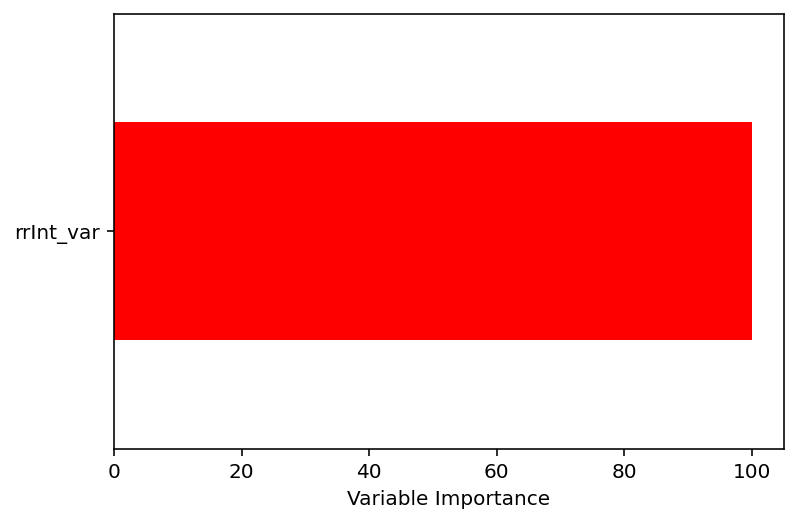

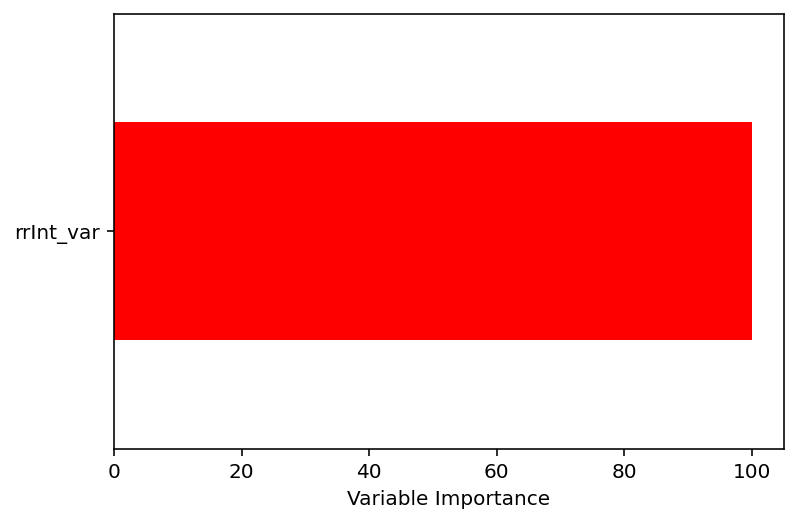

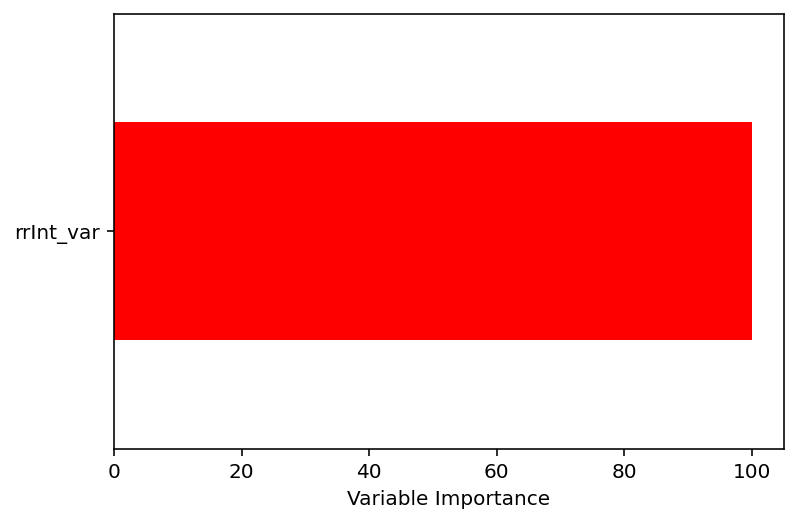

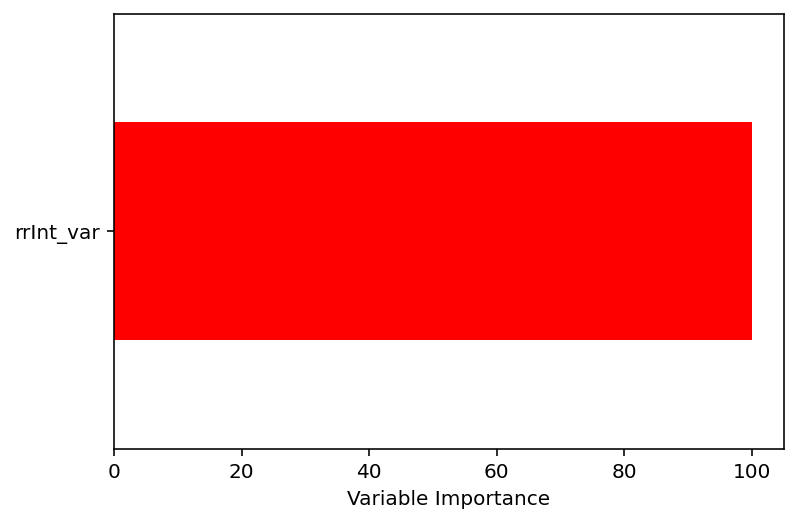

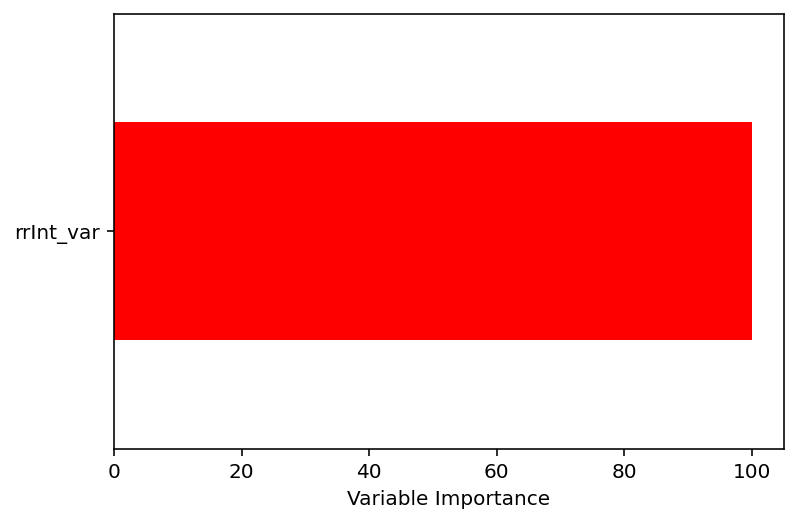

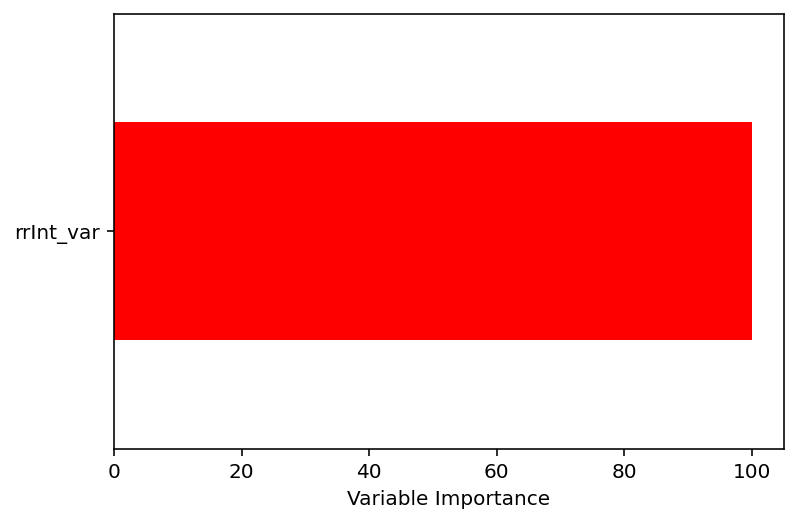

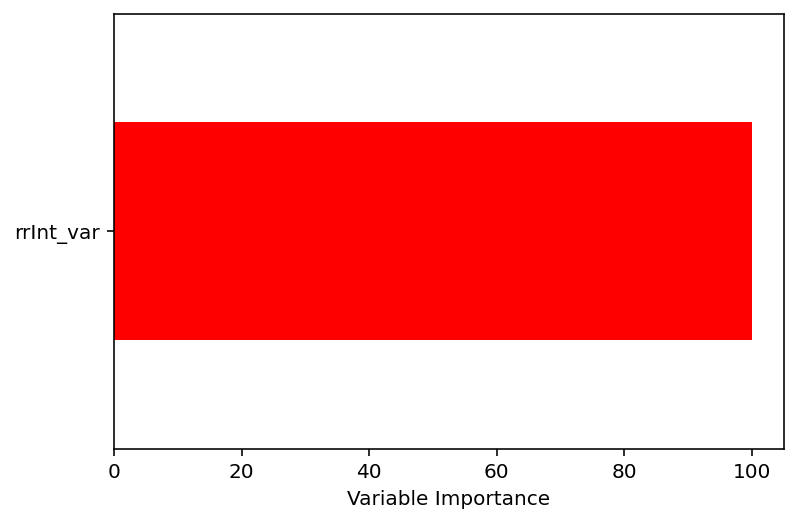

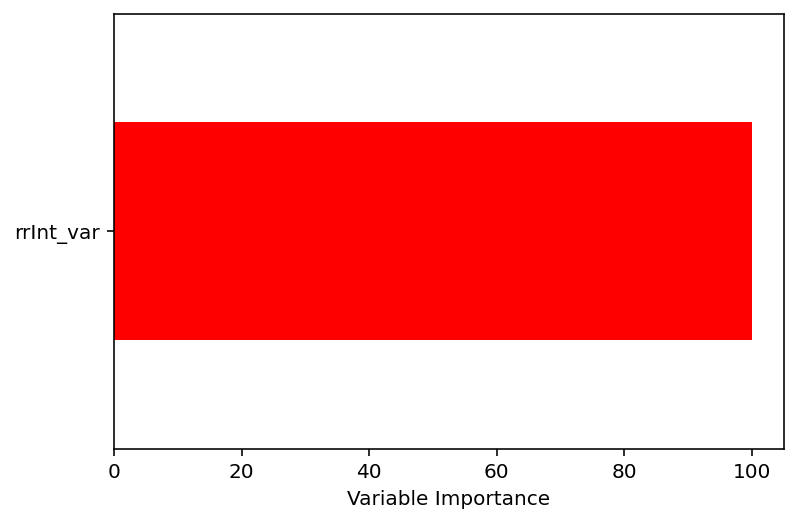

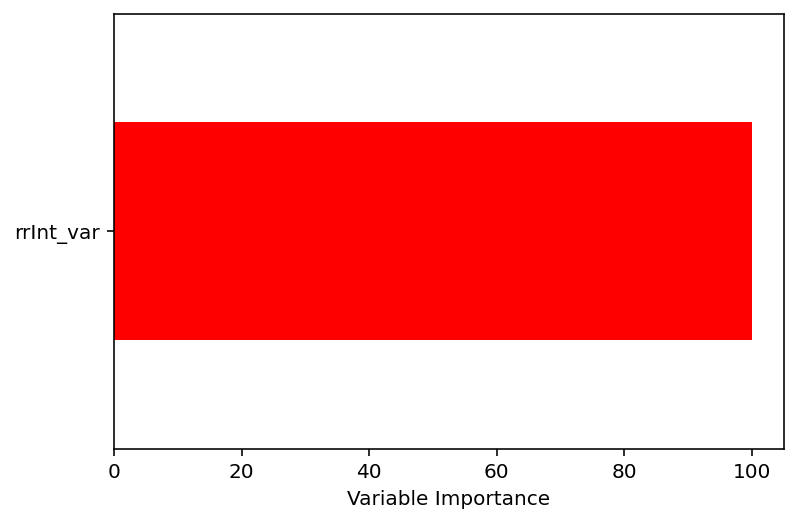

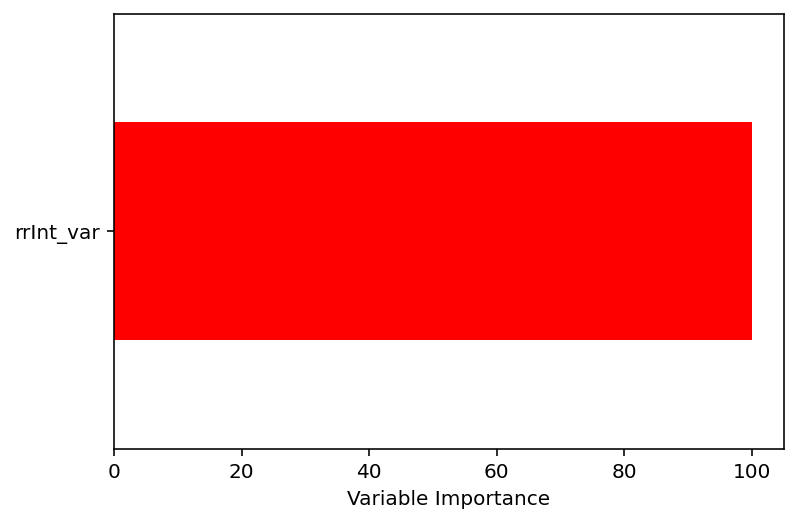

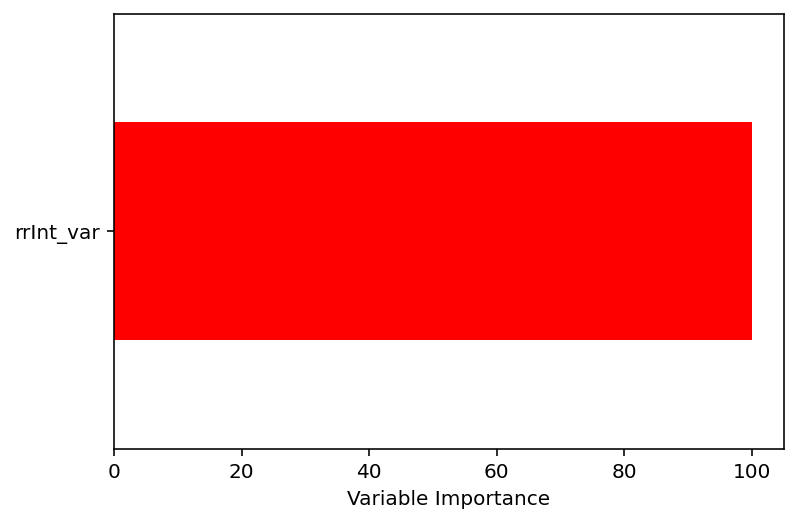

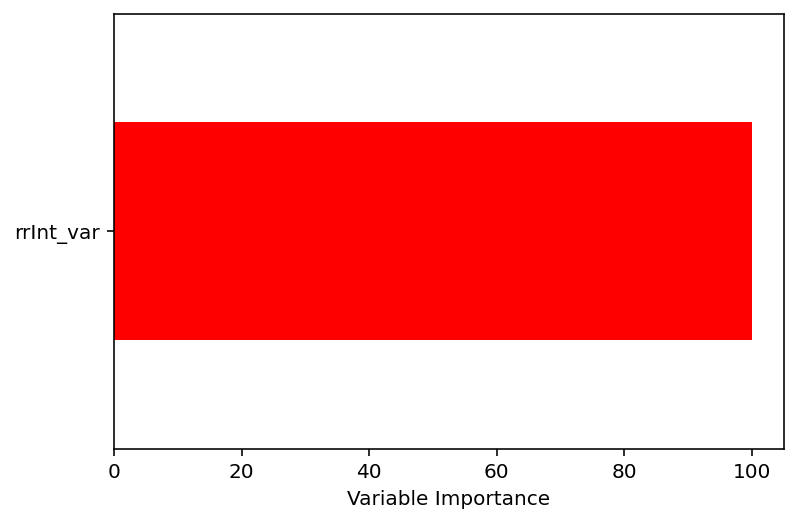

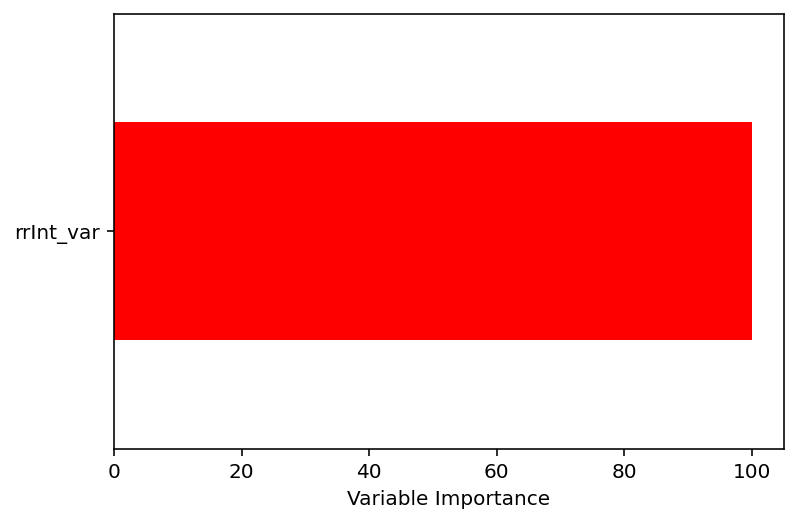

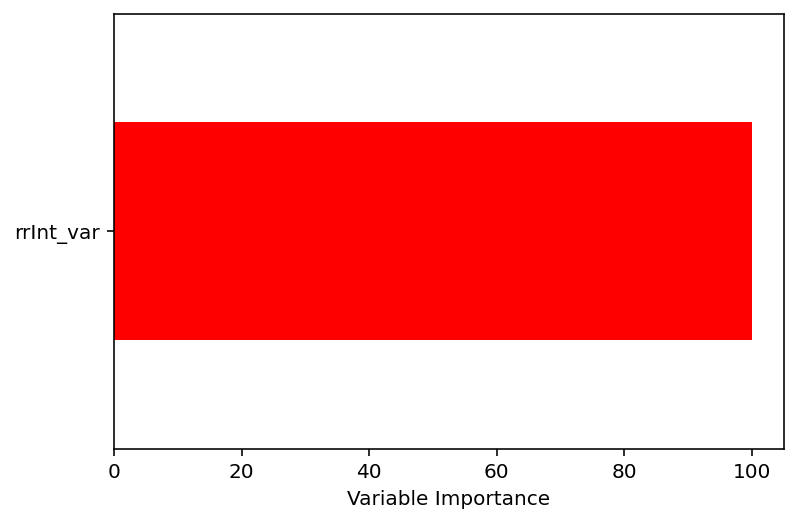

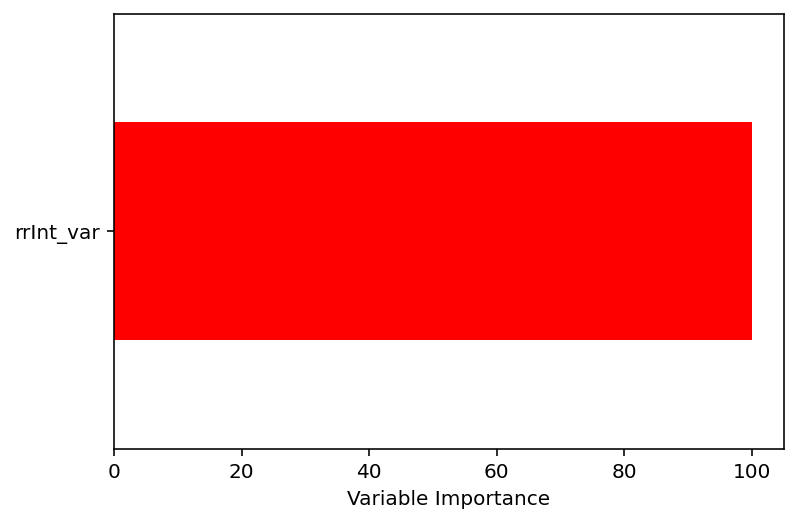

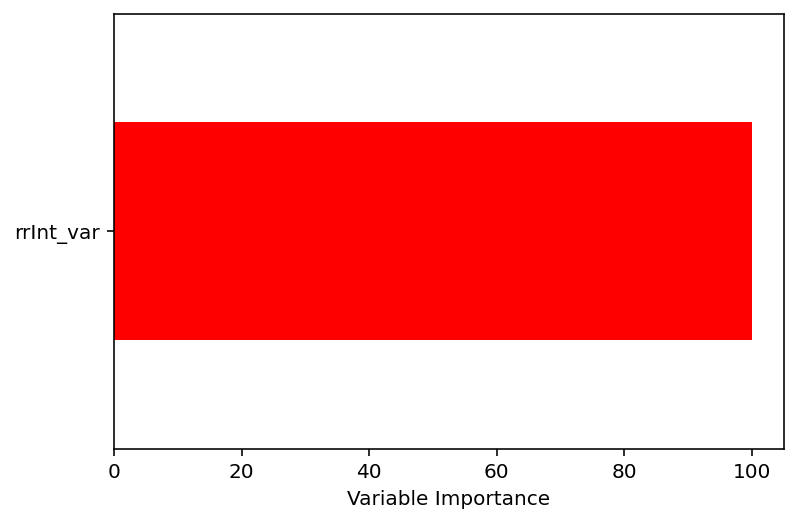

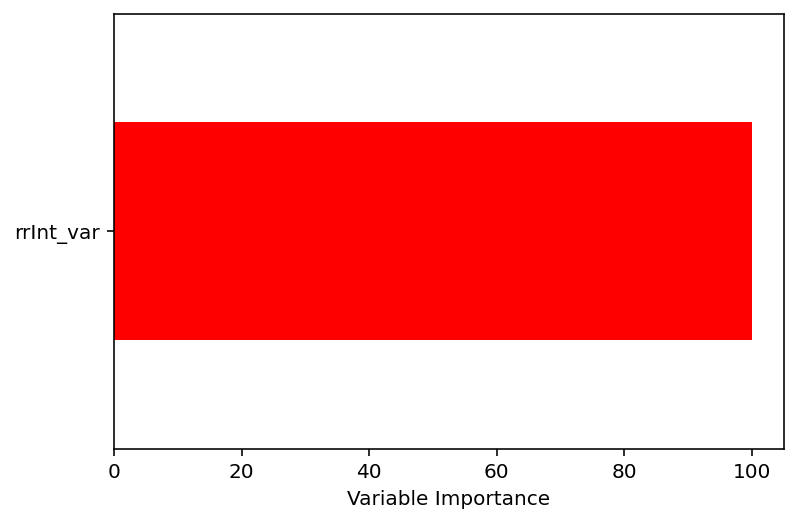

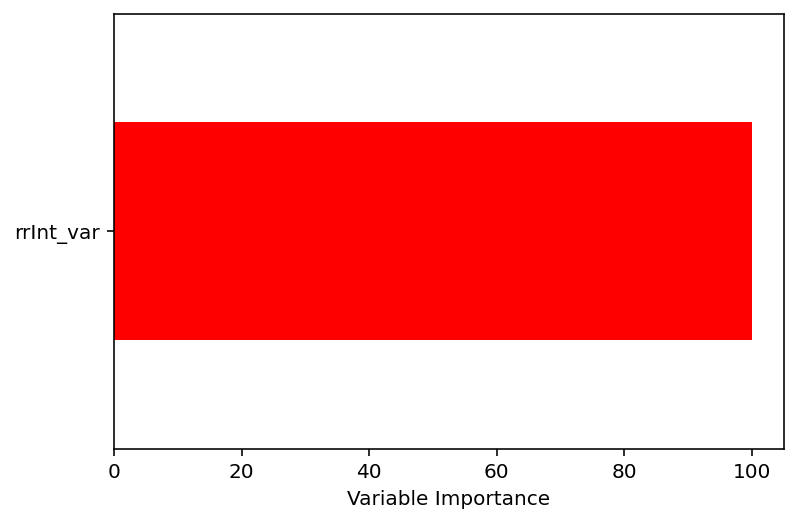

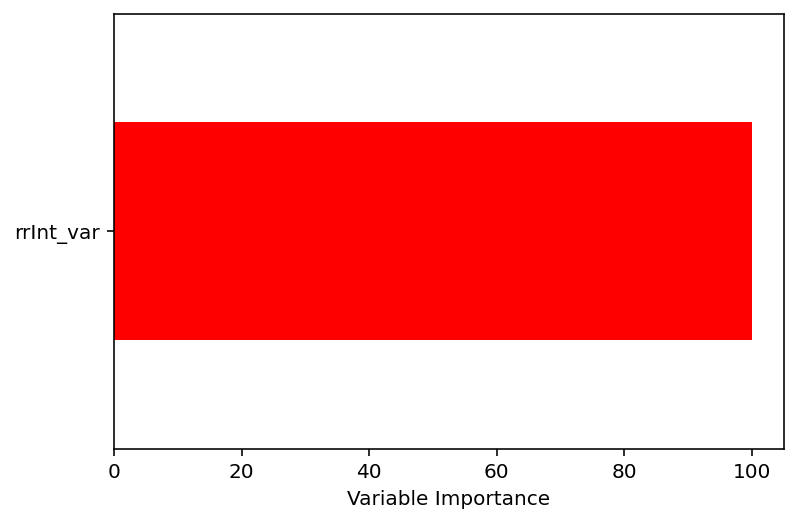

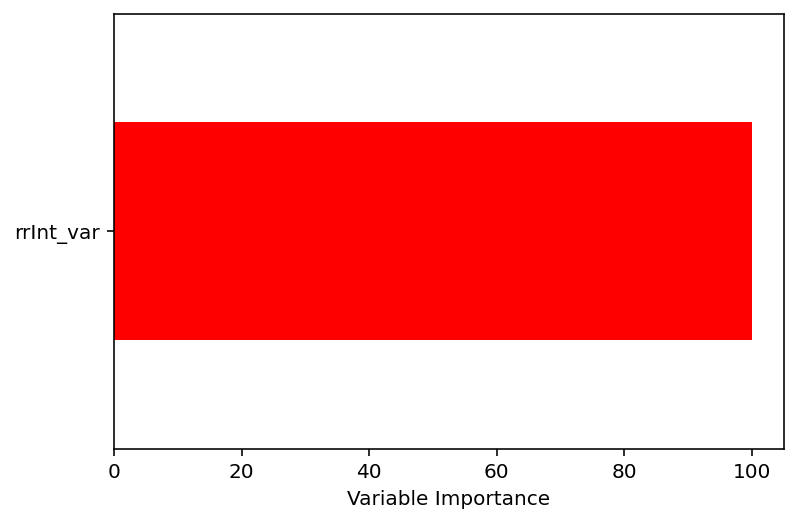

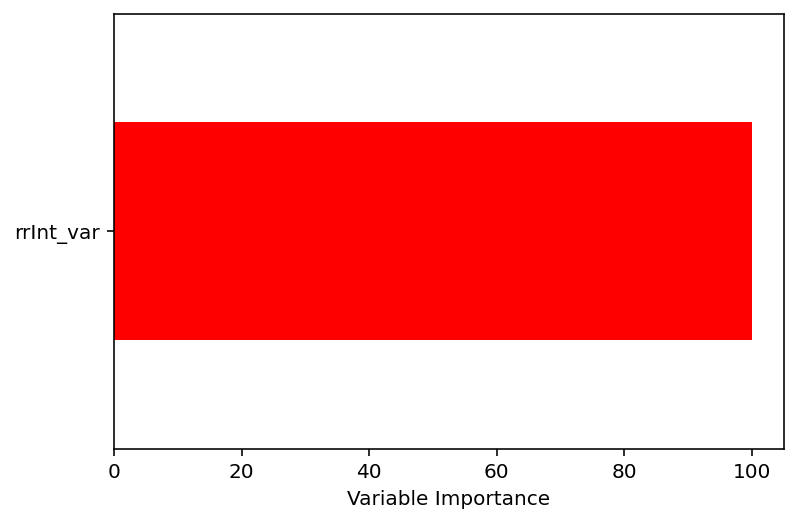

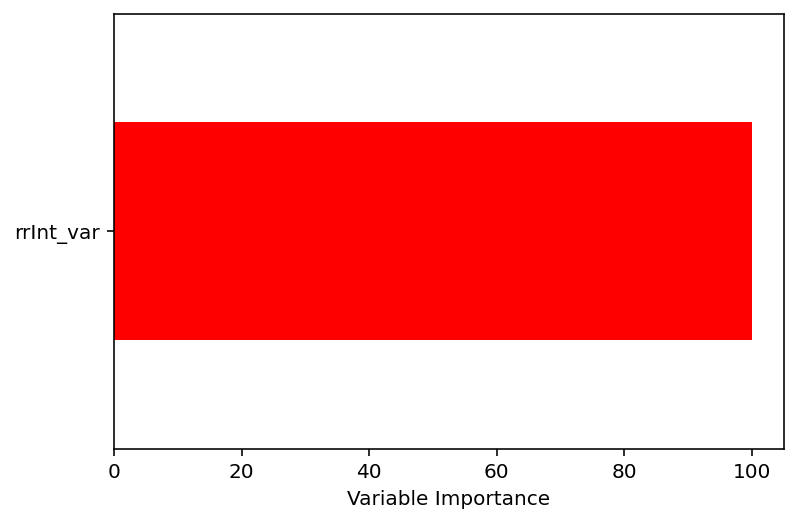

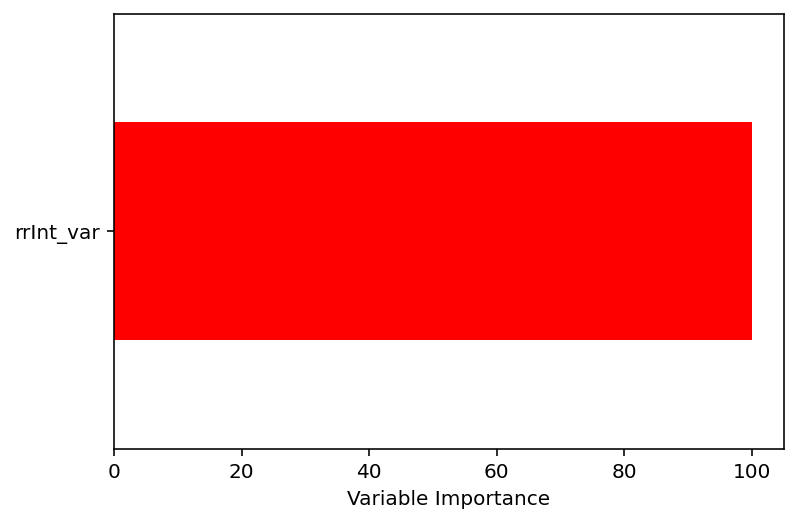

In [11]:
# LightGBM
lgbm = lightgbm.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42)

start_time = timeit.default_timer() #defines start time so computational time can be calculated

acc_score = []
Truth = []
Output = []
 
for train, test in tqdm(splits):
    X_train = X.iloc[train]
    y_train = y.iloc[train]

    X_test = X.iloc[test]
    y_test = y.iloc[test]
    
    # Create the LightGBM data containers
    model.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)],
          eval_metric='logloss')

    pred_values = model.predict(X_test)
     
    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)
    
    Truth.extend(y_test.values.reshape(y_test.shape[0])); ## it is a list
    Output.extend(pred_values); ## it is a list  
    
    #print(model.feature_importances_)
    Importance = pd.DataFrame({'Importance':(model.feature_importances_*100)[0:10]}, 
                          index = (X_train.columns)[0:10])
    Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r')
    plt.xlabel('Variable Importance')
    plt.gca().legend_ = None
    #plt.savefig('plot1.png')


elapsed = timeit.default_timer() - start_time #gives total computation time
print("---Run time is %s seconds ---" % elapsed) #prints computation time
print()

print('Accuracy of each fold: \n {}'.format(acc_score))
print()
print('Avg accuracy : \n{}'.format(np.mean(acc_score))); 
print()
print('Std of accuracy : \n{}'.format(np.std(acc_score)))

cm = confusion_matrix(Truth, Output)
print(cm)
print("classification report: ")
print(classification_report(Truth, Output))

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

performance_dict['Avg Accuracy'].append(np.mean(acc_score))
performance_dict['Std Accuracy'].append(np.std(acc_score))
performance_dict['Sensitivity'].append(sensitivity)
performance_dict['Specificity'].append(specificity)
performance_dict['Precision'].append(precision)
performance_dict['F1 score'].append(f1_score)
performance_dict['Run time'].append(elapsed)

 87%|███████████████████████████████████████████████████████████████████████▎          | 20/23 [00:12<00:01,  1.67it/s]C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\pandas\plotting\_matplotlib\core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:14<00:00,  1.64it/s]


---Run time is 14.036386699881405 seconds ---

Accuracy of each fold: 
 [0.7830485304169514, 0.9253470536841083, 0.9069381598793363, 0.3759124087591241, 0.9344303479462379, 0.8928467153284672, 0.9028244788164089, 0.8546406940579473, 0.8647377938517179, 0.5402298850574713, 0.9652164431359721, 0.7153965785381027, 0.6387799564270152, 0.7704566349984676, 0.2911720698254364, 0.814767392232181, 0.7397781824201292, 0.9415683553088133, 0.4316568647333198, 0.892838266384778, 0.9471964048616076, 0.8323769254001813, 0.928124369069251]

Avg accuracy : 
0.7778384570057838

Std of accuracy : 
0.19058820321057998
[[73114 29771]
 [11998 72674]]
classification report: 
              precision    recall  f1-score   support

           0       0.86      0.71      0.78    102885
           1       0.71      0.86      0.78     84672

    accuracy                           0.78    187557
   macro avg       0.78      0.78      0.78    187557
weighted avg       0.79      0.78      0.78    187557



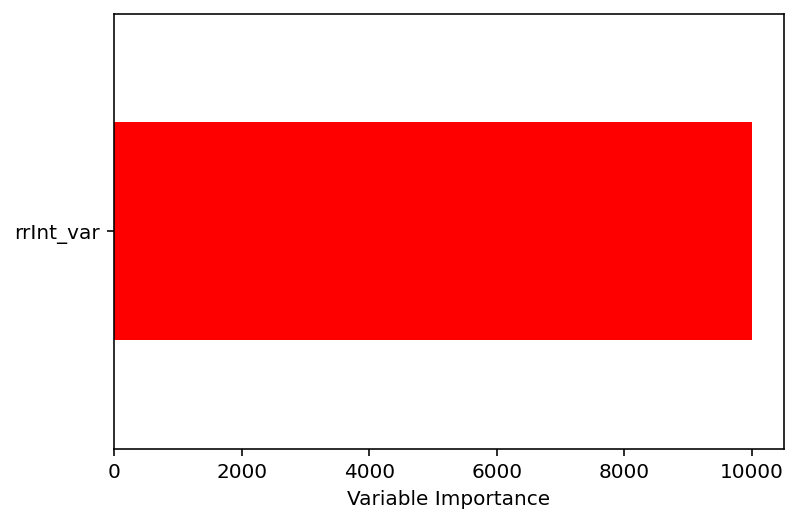

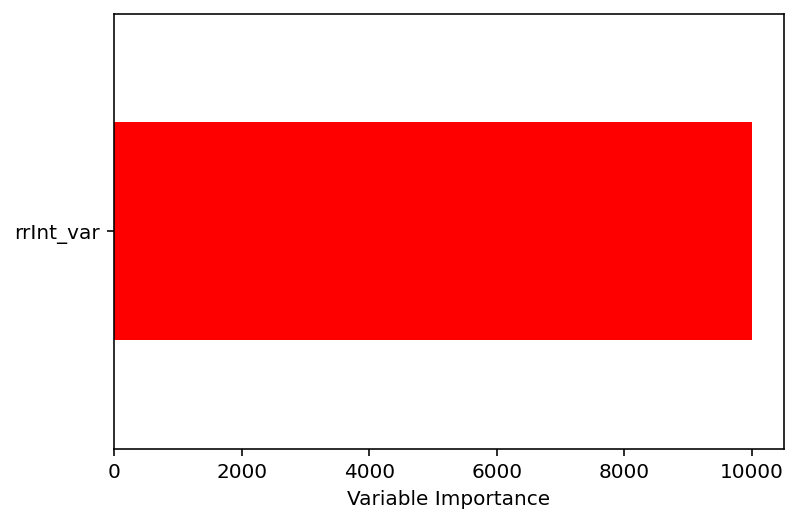

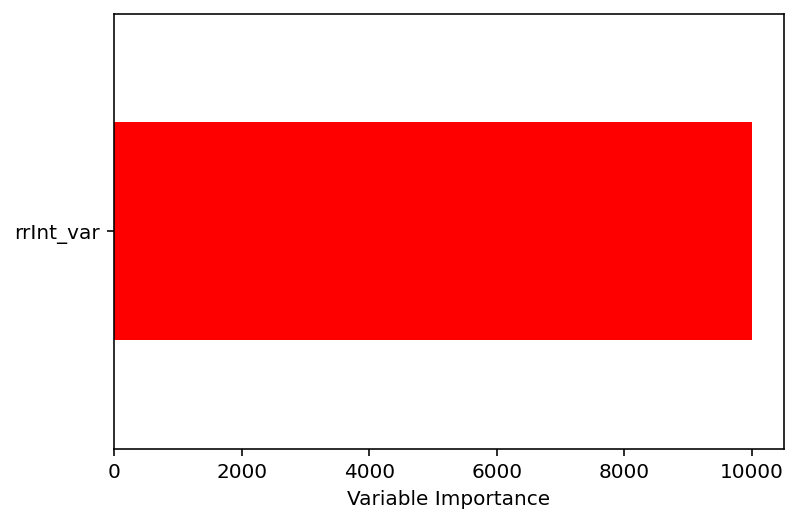

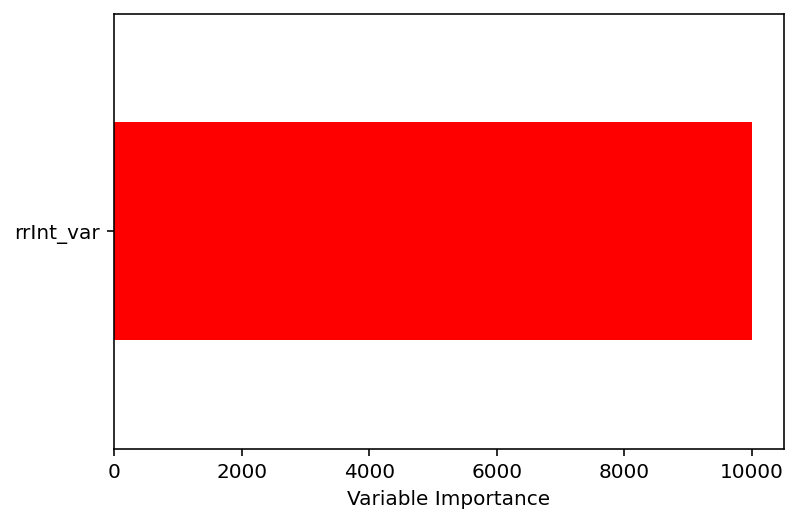

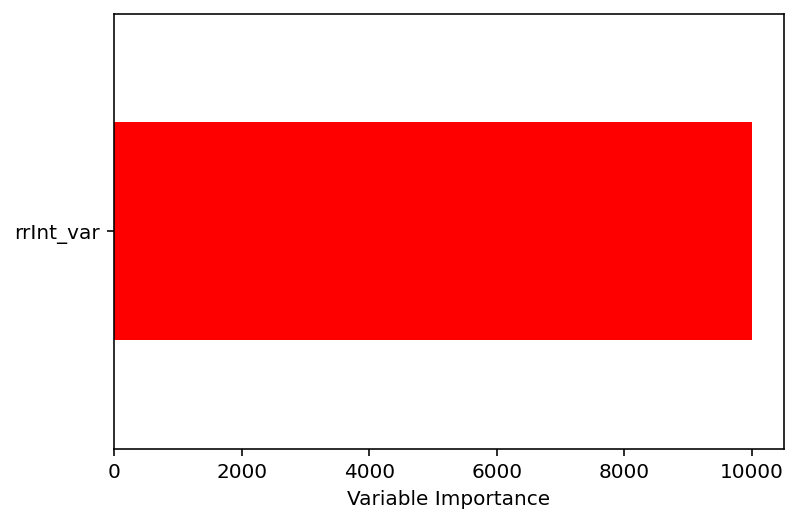

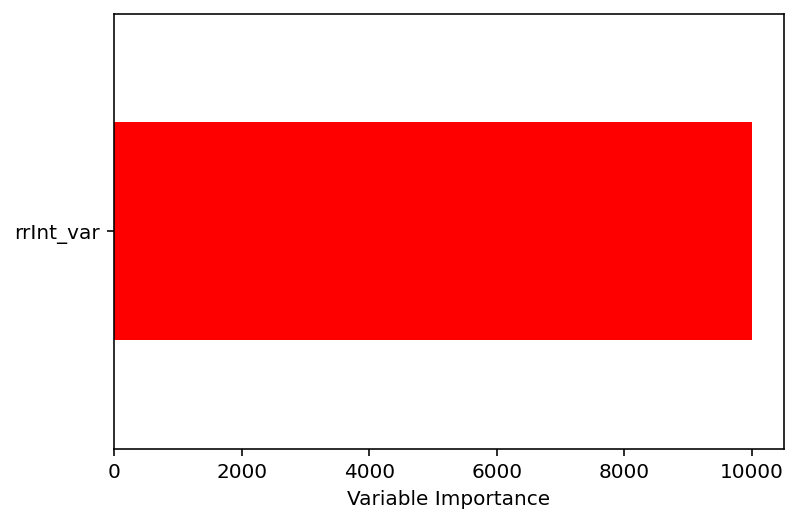

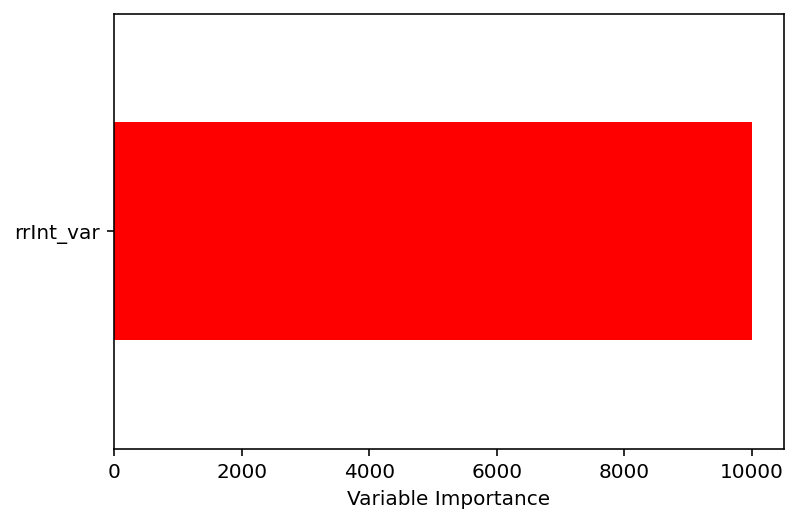

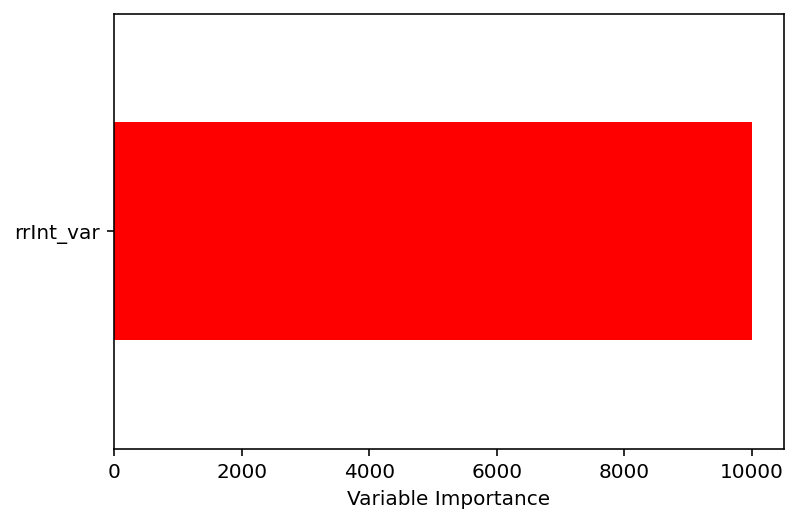

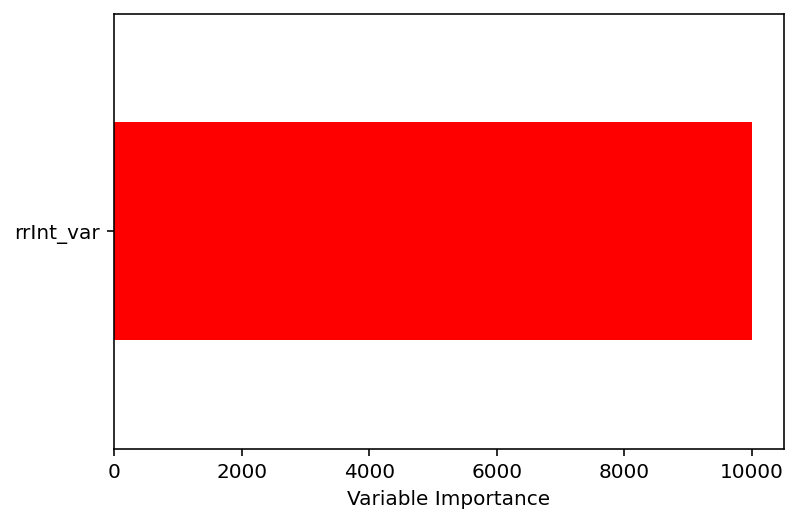

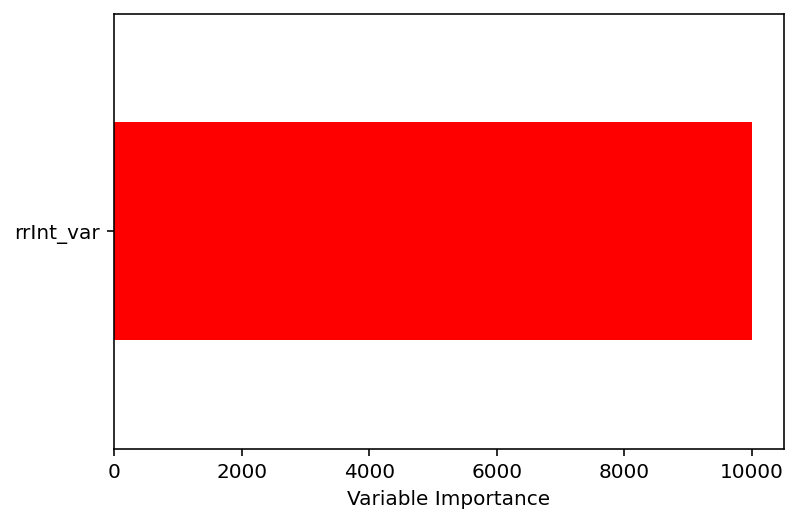

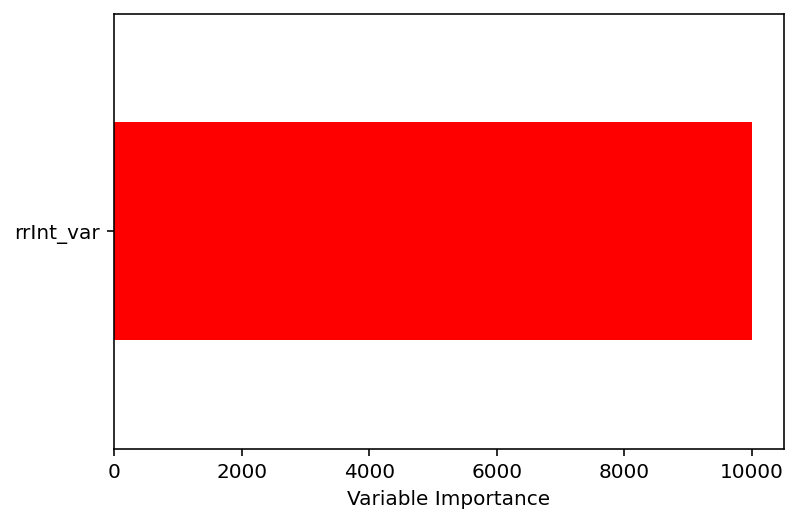

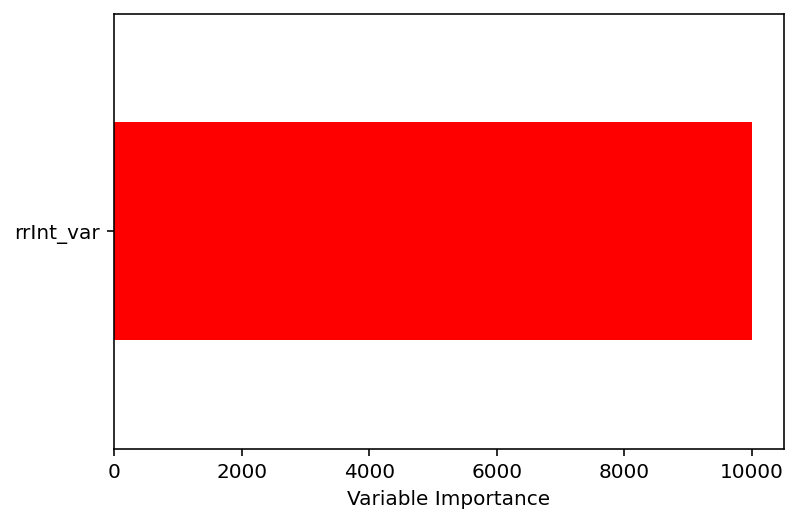

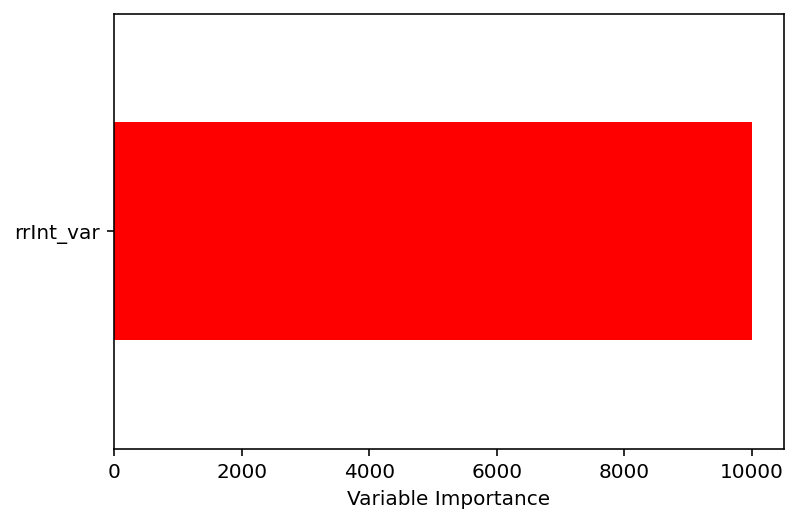

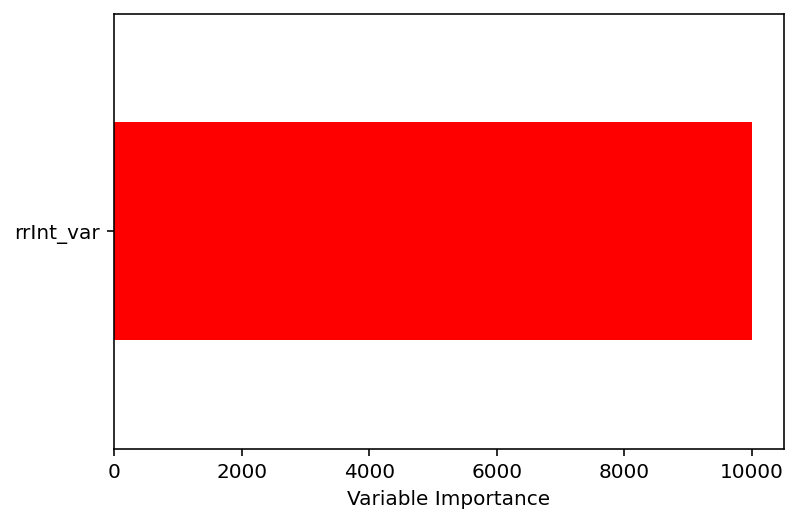

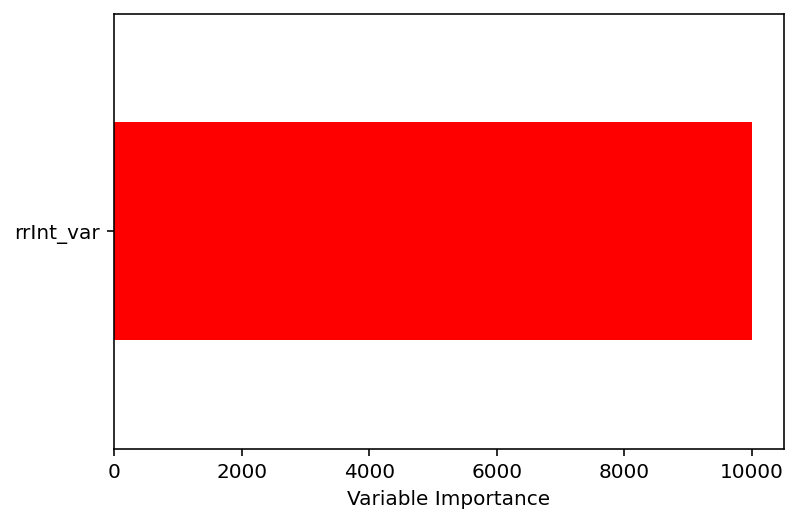

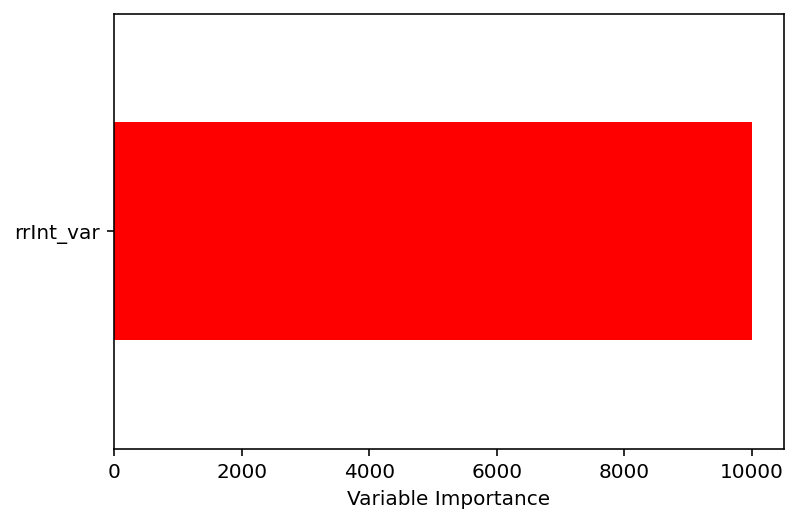

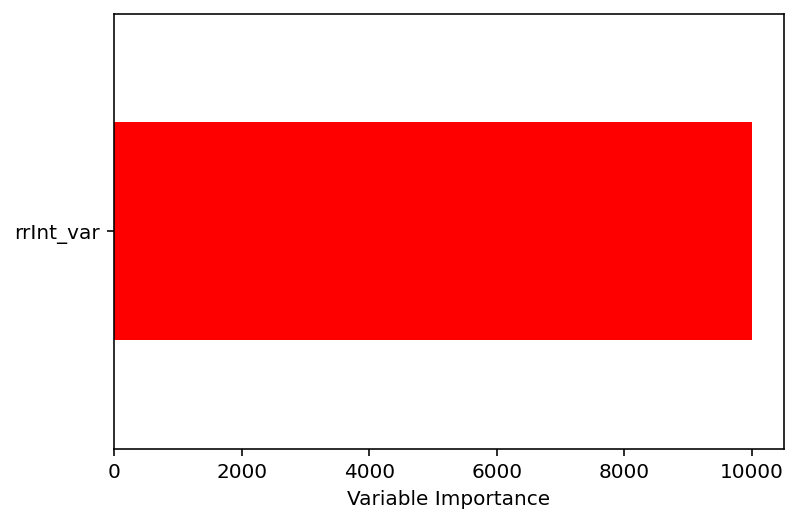

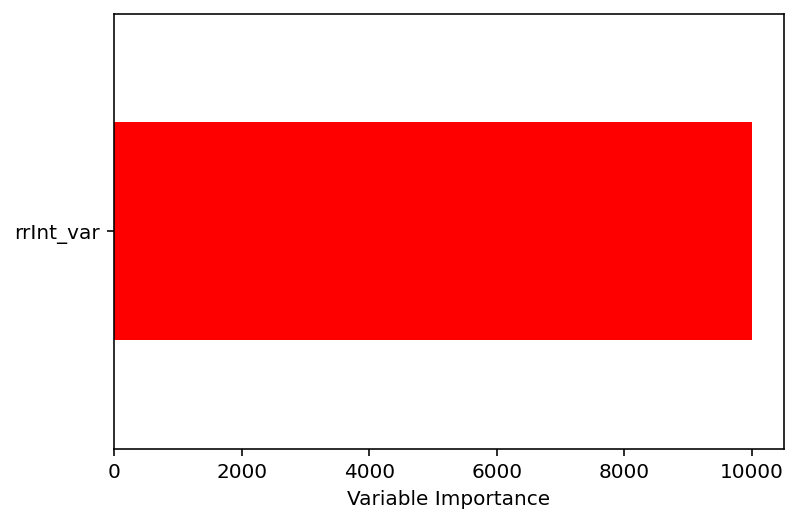

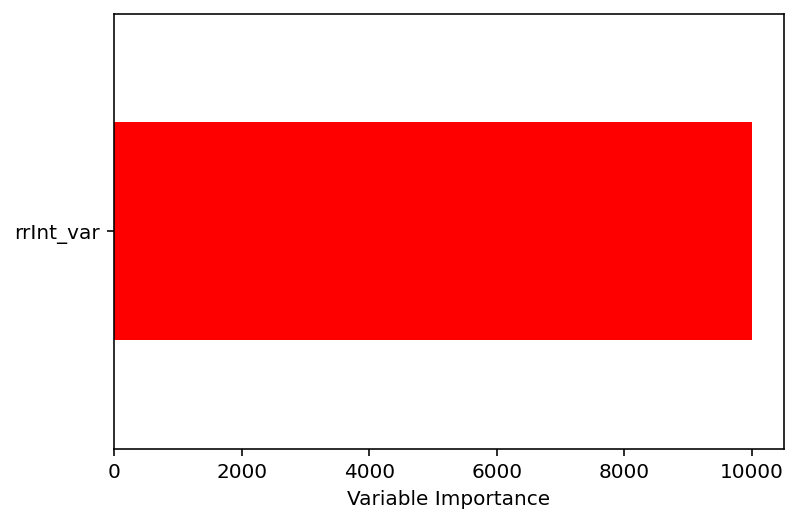

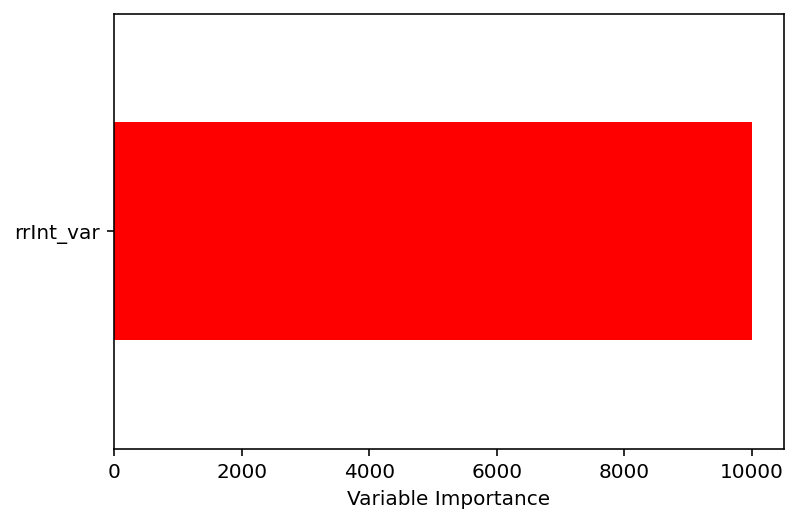

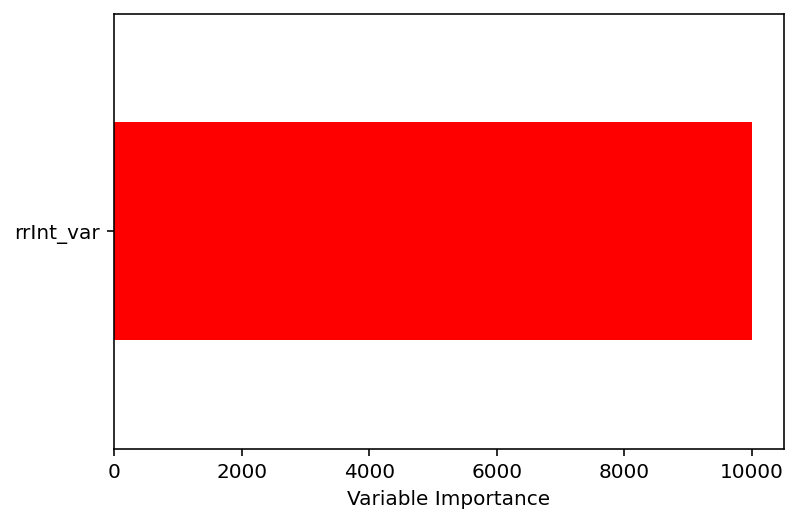

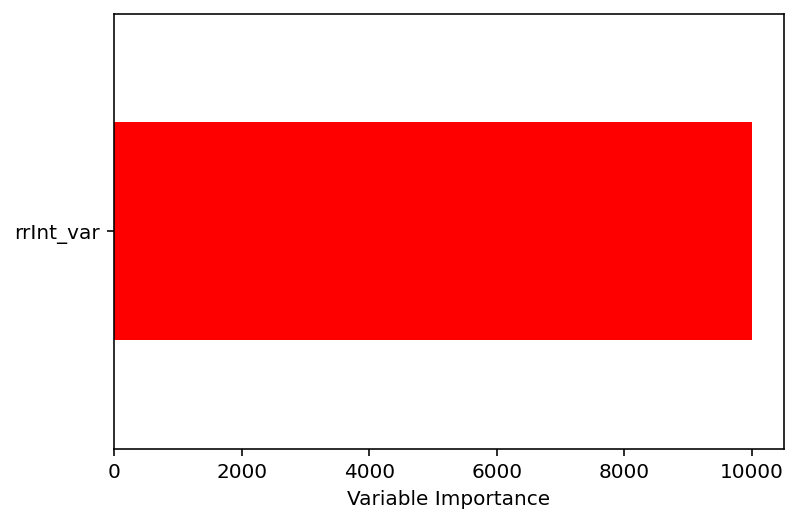

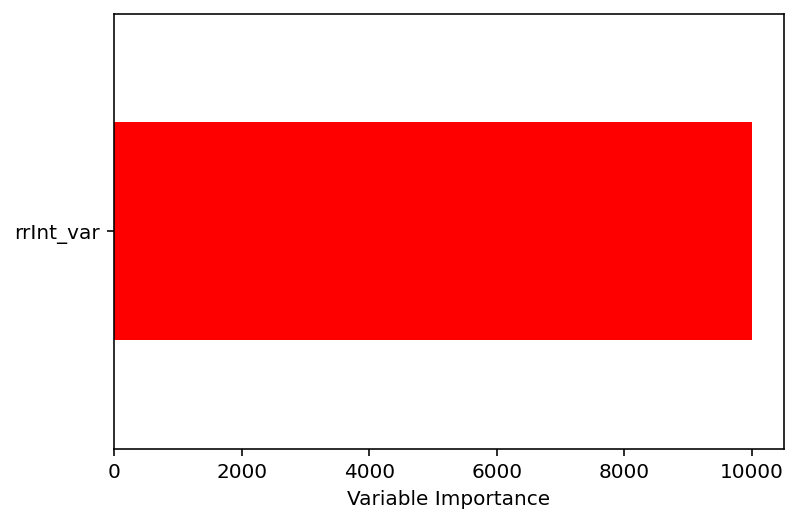

In [12]:
# CatBoost
start_time = timeit.default_timer() #defines start time so computational time can be calculated

acc_score = []
Truth = []
Output = []
 
for train, test in tqdm(splits):
    X_train = X.iloc[train]
    y_train = y.iloc[train]

    X_test = X.iloc[test]
    y_test = y.iloc[test]
    
    # Create CatBoost model
    model = CatBoostClassifier(iterations=100,
                           depth=4,
                           learning_rate=0.1,
                           loss_function='Logloss')
    # train the model
    model.fit(X_train, y_train, verbose=False)
    
    # make the prediction using the resulting model
    pred_values = model.predict(X_test)
    #preds_proba = model.predict_proba(test_data)
    #print("class = ", preds_class)
    #print("proba = ", preds_proba)
     
    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)
    
    Truth.extend(y_test.values.reshape(y_test.shape[0])); ## it is a list
    Output.extend(pred_values); ## it is a list  
    
    #print(model.feature_importances_)
    Importance = pd.DataFrame({'Importance':(model.feature_importances_*100)[0:10]}, 
                          index = (X_train.columns)[0:10])
    Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r')
    plt.xlabel('Variable Importance')
    plt.gca().legend_ = None
    #plt.savefig('plot1.png')


elapsed = timeit.default_timer() - start_time #gives total computation time
print("---Run time is %s seconds ---" % elapsed) #prints computation time
print()

print('Accuracy of each fold: \n {}'.format(acc_score))
print()
print('Avg accuracy : \n{}'.format(np.mean(acc_score))); 
print()
print('Std of accuracy : \n{}'.format(np.std(acc_score)))

cm = confusion_matrix(Truth, Output)
print(cm)
print("classification report: ")
print(classification_report(Truth, Output))

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

performance_dict['Avg Accuracy'].append(np.mean(acc_score))
performance_dict['Std Accuracy'].append(np.std(acc_score))
performance_dict['Sensitivity'].append(sensitivity)
performance_dict['Specificity'].append(specificity)
performance_dict['Precision'].append(precision)
performance_dict['F1 score'].append(f1_score)
performance_dict['Run time'].append(elapsed)

In [13]:
performance_df = pd.DataFrame(performance_dict)
performance_df

,Avg Accuracy,Std Accuracy,Sensitivity,Specificity,Precision,F1 score,Run time
0,0.801352,0.167400,0.712388,0.947197,0.953219,0.815392,91.283394
1,0.778343,0.192548,0.712388,0.856174,0.857521,0.778246,103.130259
2,0.777838,0.190588,0.710638,0.858300,0.859033,0.777821,14.036387
